In [1]:
import os
print(os.listdir())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import re
from tqdm import tqdm
import random

from collections import defaultdict
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

['catboost_info', '.cache', '.config', 'Data_Search-Copy_21983.ipynb', 'Data_Search-Copy.ipynb', 'Data_Search-Copy_21308-Copy1.ipynb', 'Data_Search-Final.ipynb', '.ipynb_checkpoints', '.local', '.nv', 'data', 'images.zip', '.vscode-server', 'Data_Search.ipynb', '.wget-hsts', '(미션-1) EDA.ipynb', 'Untitled Folder', 'Optuna-Catboost-5Fold.ipynb', 'code', '.jupyter', 'Data_Search-\x08Final-Optuna.ipynb', 'level1_bookratingprediction-recsys-02', 'books.csv', 'images', '.ipython', '.dotnet', 'Data_Search-Classification.ipynb', '.bash_history', 'Optuna-Catboost-10Fold.ipynb', 'users.csv', '.gitconfig', 'ratings.csv', 'Data_Search-Copy_21308.ipynb', 'Optuna-Catboost-Bagging-10.ipynb', '.profile']


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
seed = 42  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def str_lower(x):
    try:
        return x.lower()
    except:
        return x

In [4]:
path = '.'
data_path = path + '/data'
books_path = data_path + '/books.csv'
users_path = data_path + '/users.csv'
train_ratings_path = data_path + '/train_ratings.csv'
test_ratings_path = data_path + '/test_ratings.csv'

In [5]:
df_books = pd.read_csv(books_path)
df_users = pd.read_csv(users_path)
df_train_ratings = pd.read_csv(train_ratings_path)
df_test_ratings = pd.read_csv(test_ratings_path)

print('users shape: ', df_users.shape)
print('books shape: ', df_books.shape)
print('train ratings shape: ', df_train_ratings.shape)
print('test ratings shape: ', df_test_ratings.shape)

df_users['user_id'] = df_users['user_id'].astype(str)
df_train_ratings['user_id'] = df_train_ratings['user_id'].astype(str)
df_test_ratings['user_id'] = df_test_ratings['user_id'].astype(str)

users shape:  (68092, 3)
books shape:  (149570, 10)
train ratings shape:  (306795, 3)
test ratings shape:  (76699, 3)


In [6]:
# 성능평가는 Cross Validation으로 대체함 -> Public Leader Board에서 최종 성능평가

In [7]:
# Cold_start, user_id, isbn을 제외하고 FeatureSet을 구성해야할 것 같음

train_user_id = set(df_train_ratings['user_id'].unique())
train_isbn = set(df_train_ratings['isbn'].unique())
print('train_user_id : {}, train_isbn : {}'.format(len(train_user_id), len(train_isbn)))

test_user_id = set(df_test_ratings['user_id'].unique())
test_isbn = set(df_test_ratings['isbn'].unique())
print('test_user_id : {}, test_isbn : {}'.format(len(test_user_id), len(test_isbn)))

users_user_id = set(df_users['user_id'].unique())
books_isbn = set(df_books['isbn'].unique())
print('users_user_id : {}, books_isbn : {}'.format(len(users_user_id), len(books_isbn)))

print()
print('Subtraction set A - set B')
print('test_user_id - train_user_id : {}'.format(len(test_user_id - train_user_id)))
print('test_isbn - train_user_id : {}'.format(len(test_isbn - train_isbn)))
print('train_user_id - users_user_id : {}'.format(len(train_user_id - users_user_id)))
print('train_isbn - books_isbn : {}'.format(len(train_isbn - books_isbn)))
print('test_user_id - users_user_id : {}'.format(len(test_user_id - users_user_id)))
print('test_isbn - books_isbn : {}'.format(len(test_isbn - books_isbn)))

train_user_id : 59803, train_isbn : 129777
test_user_id : 26167, test_isbn : 52000
users_user_id : 68092, books_isbn : 149570

Subtraction set A - set B
test_user_id - train_user_id : 8266
test_isbn - train_user_id : 19793
train_user_id - users_user_id : 0
train_isbn - books_isbn : 0
test_user_id - users_user_id : 0
test_isbn - books_isbn : 0


In [8]:
# train의 user_id와 isbn 둘 다 해당 안되는 test의 경우는?

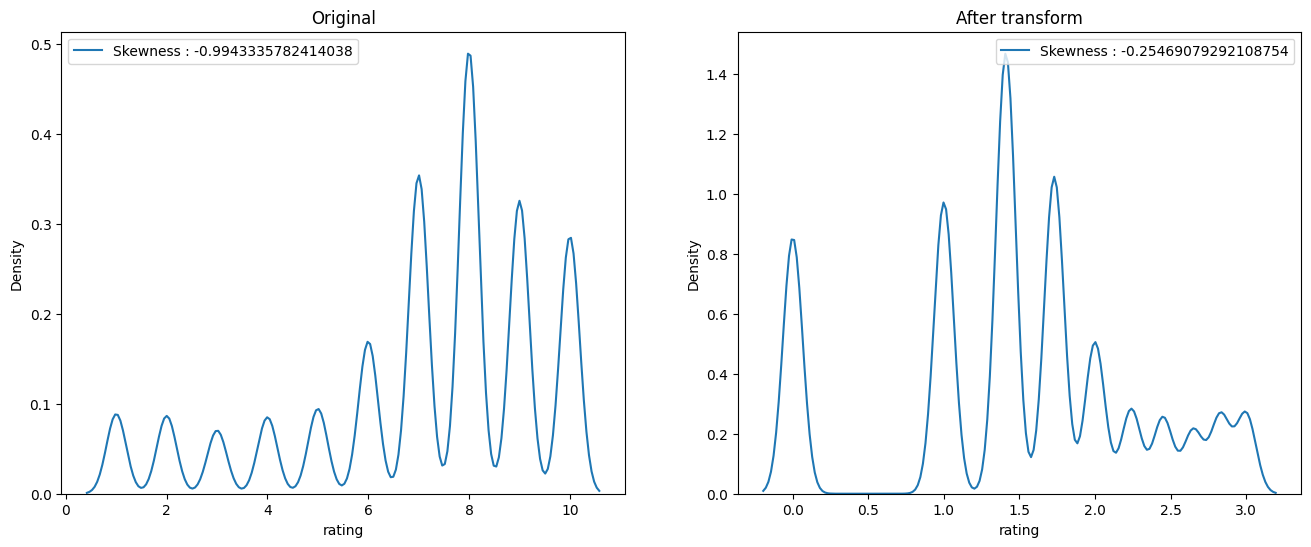

In [9]:
# Explicit Feedback Imbalance

f, ax = plt.subplots(1,2,figsize = (16,6))

# df_train_ratings['rating'].value_counts(True).sort_index().plot.bar(ax = ax[0])
# ax[0].set_title('Original')
# ax[0].legend(['Skewness : {}'.format(df_train_ratings['rating'].skew())])

# df_train_ratings['rating'].apply(lambda x : round(np.sqrt(10 - x), 2)).value_counts(True).sort_index().plot.bar(ax = ax[1])
# ax[1].set_title('After transform')
# ax[1].legend(['Skewness : {}'.format(df_train_ratings['rating'].apply(lambda x : round(np.log1p(10 - x), 2)).skew())])

sns.kdeplot(df_train_ratings['rating'], ax = ax[0])
ax[0].set_title('Original')
ax[0].legend(['Skewness : {}'.format(df_train_ratings['rating'].skew())])

sns.kdeplot(df_train_ratings['rating'].apply(lambda x : round(np.sqrt(10 - x), 2)), ax = ax[1])
ax[1].set_title('After transform')
ax[1].legend(['Skewness : {}'.format(df_train_ratings['rating'].apply(lambda x : round(np.log1p(10 - x), 2)).skew())])

## Users

In [10]:
for column in df_users.columns:
    if column == 'user_id':
        continue
    if df_users[column].dtype == object:
        print(column)
        df_users[column] = df_users[column].apply(str_lower)

location


In [11]:
# Location에도 결측치가 존재할 수 있음을 암시
df_users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [12]:
# Age 결측치
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  object 
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [13]:
df_users.isna().mean()

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

In [14]:
df_users.duplicated().sum()

0

In [15]:
df_users.describe()

,age
count,40259.000000
mean,36.069873
std,13.842571
min,5.000000
25%,25.000000
50%,34.000000
75%,45.000000
max,99.000000


In [16]:
df_users['user_id'].nunique()

68092

In [17]:
df_users['location'] = df_users['location'].apply(lambda x : re.sub(r'[^a-zA-Z,]', '', x))

df_users['location_city'] = df_users['location'].apply(lambda x: x.split(',')[0].strip())
df_users['location_state'] = df_users['location'].apply(lambda x: x.split(',')[1].strip())
df_users['location_country'] = df_users['location'].apply(lambda x: x.split(',')[2].strip())

df_users = df_users.replace('na', np.nan)
df_users = df_users.replace('', np.nan)

In [18]:
# Location에도 결측치 존재함
df_users.isna().agg(['sum', 'mean']).T

,sum,mean
user_id,0.0,0.000000
location,0.0,0.000000
age,27833.0,0.408756
location_city,129.0,0.001894
location_state,3254.0,0.047788
location_country,2124.0,0.031193


In [19]:
# Cardinality : country < state < city
df_users['location_country'].nunique(), df_users['location_state'].nunique(), df_users['location_city'].nunique()

(316, 1499, 11958)

In [20]:
cset_location_city = set(df_users[~df_users['location_city'].isna()].index)
set_location_state = set(df_users[df_users['location_state'].isna()].index)
set_location_country = set(df_users[df_users['location_country'].isna()].index)

print('set_location_state - cset_location_city : {}'.format(len(set_location_state - cset_location_city)))
print('set_location_country - cset_location_city : {}'.format(len(set_location_country - cset_location_city)))

set_location_state - cset_location_city : 58
set_location_country - cset_location_city : 11


In [21]:
# city에 잘못된 country 배정되어 있는 경우가 있음
temp = df_users.groupby('location_city')['location_country'].value_counts().reset_index()
temp[temp['location_city'] == 'seattle']

,location_city,location_country,count
10059,seattle,usa,544
10060,seattle,australia,1
10061,seattle,canada,1
10062,seattle,unitedkingdom,1
10063,seattle,washington,1


In [22]:
temp = df_users.groupby('location_city')['location_country'].value_counts().groupby('location_city').idxmax().apply(lambda x : x[-1]).reset_index().rename(columns = {'count':'location_country'})
city2country = dict(zip(temp['location_city'].values, temp['location_country'].values))

temp = df_users.groupby('location_city')['location_state'].value_counts().groupby('location_city').idxmax().apply(lambda x : x[-1]).reset_index().rename(columns = {'count':'location_state'})
city2state = dict(zip(temp['location_city'].values, temp['location_state'].values))

df_users['location_country'] = df_users['location_city'].map(city2country)
df_users['location_state'] = df_users['location_city'].map(city2state)

In [23]:
# Location 결측치 일부 완화
df_users.isna().agg(['sum', 'mean']).T

,sum,mean
user_id,0.0,0.000000
location,0.0,0.000000
age,27833.0,0.408756
location_city,129.0,0.001894
location_state,541.0,0.007945
location_country,290.0,0.004259


In [24]:
# Cardinality 일부 완화
df_users['location_country'].nunique(), df_users['location_state'].nunique(), df_users['location_city'].nunique()

(204, 1039, 11958)

In [25]:
# city에 잘못된 country 배정되어 있는 경우 해결
temp = df_users.groupby('location_city')['location_country'].value_counts().reset_index()
temp[temp['location_city'] == 'seattle']

,location_city,location_country,count
9346,seattle,usa,572


In [26]:
df_users[df_users['location_country'] == 'japan']

,user_id,location,age,location_city,location_state,location_country
1442,110609,"osaka,na,japan",32.0,osaka,NaN,japan
1461,114178,"tokyo,tokyo,japan",30.0,tokyo,tokyo,japan
4294,14897,"shiki,saitama,japan",24.0,shiki,saitama,japan
9086,265643,"zushi,na,japan",34.0,zushi,NaN,japan
9118,278554,"takasaki,gunma,japan",22.0,takasaki,gunma,japan
...,...,...,...,...,...,...
61079,128424,"yokosuka,yokosuka,japan",16.0,yokosuka,yokosuka,japan
61844,124738,"kobe,na,japan",33.0,kobe,hyogo,japan
64020,242844,"utsunomiya,tochigi,japan",29.0,utsunomiya,tochigi,japan
64651,141426,"shinjuku,tokyo,japan",29.0,shinjuku,tokyo,japan


In [27]:
# state의 개념이 없는 나라가 있음
# wilfleinsdorf -> Austria
null_index = df_users[(df_users['location_city'].isna()) | (df_users['location_state'].isna()) | (df_users['location_country'].isna())].index
temp = df_users.loc[null_index]
temp[(temp['location_city'].notna()) | (temp['location_state'].notna()) | (temp['location_country'].notna())]

,user_id,location,age,location_city,location_state,location_country
633,271622,"malmok,na,aruba",NaN,malmok,NaN,aruba
1291,88142,"santiagocity,na,philippines",19.0,santiagocity,NaN,philippines
1334,94101,"zambrow,na,poland",21.0,zambrow,NaN,poland
1442,110609,"osaka,na,japan",32.0,osaka,NaN,japan
1447,111162,"kathmandu,na,nepal",18.0,kathmandu,NaN,nepal
...,...,...,...,...,...,...
67515,240438,"wilfleinsdorf,niederoesterreich,",16.0,wilfleinsdorf,niederoesterreich,NaN
67530,257375,"vanlse,na,denmark",32.0,vanlse,NaN,denmark
67889,265227,"bandarseribegawan,na,brunei",14.0,bandarseribegawan,NaN,brunei
67973,270244,"sincity,na,singapore",21.0,sincity,NaN,singapore


In [28]:
# country만 사용할거라면 채워야됨..
# Age는 읽은 책과 매칭 시켜서 넣을 생각

null_index = df_users[(df_users['location_city'].isna()) | (df_users['location_state'].isna()) | (df_users['location_country'].isna())].index
temp = df_users.loc[null_index]
temp[((temp['location_city'].notna()) | (temp['location_state'].notna())) & (temp['location_country'].isna())]

,user_id,location,age,location_city,location_state,location_country
1879,181316,"managua,,",36.0,managua,NaN,NaN
2020,205019,"aladinma,imostate,na,nigeria",29.0,aladinma,imostate,NaN
2183,227295,"llanelli,,",NaN,llanelli,NaN,NaN
2743,53456,"neportland,oregon,",NaN,neportland,oregon,NaN
3169,28372,"northapollo,,",NaN,northapollo,NaN,NaN
...,...,...,...,...,...,...
64296,121778,"lakecormorant,mississippi,",NaN,lakecormorant,mississippi,NaN
64760,133843,"letart,westvirginia,",16.0,letart,westvirginia,NaN
65142,146516,"saronno,lombardia,",31.0,saronno,lombardia,NaN
66518,192259,"grossenseebach,,",36.0,grossenseebach,NaN,NaN


In [29]:
# df_users['location'] = df_users['location'].apply(lambda x: ','.join(map(str, ['na' if '' == i else i for i in x.split(',')])))

# modify_location = set(df_users[(df_users['location_state'].isna()) & ((df_users['location_city'].notnull()))]['location_city'].values)

# location_list = []
# for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
#     try:
#         candidates = df_users[(df_users['location_city']==location) & ((df_users['location_city'].notnull()))]['location'].value_counts()
#         first = candidates.idxmax()
#         for k, v in dict(candidates).items():
#             k = k.split(',')
#             if 'na' not in k:
#                 right_location = ','.join(map(str, k))
#                 break
#         else:
#             right_location = first
#         location_list.append(right_location)
#     except:
#         pass

# for location in tqdm(location_list): # [지역, 주, 국가]
#     df_users.loc[df_users[(df_users['location_city']==location.split(',')[0]) & (df_users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]

# # state의 결측치를 country의 정보를 활용해 채워보자
# modify_location = set(df_users[(df_users['location_state'].isna()) & ((df_users['location_country'].notnull()))]['location_country'].values)

# location_list = []
# for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
#     try:
#         candidates = df_users[(df_users['location_country']==location) & ((df_users['location_country'].notnull()))]['location'].value_counts()
#         first = candidates.idxmax()
#         for k, v in dict(candidates).items():
#             k = k.split(',')
#             if 'na' not in k:
#                 right_location = ','.join(map(str, k))
#                 break
#         else:
#             right_location = first
#         location_list.append(right_location)
#     except:
#         pass

# for location in tqdm(location_list): # [지역, 주, 국가]
#     df_users.loc[df_users[(df_users['location_country']==location.split(',')[2]) & (df_users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]


# ## country 채우기
# # country의 결측치를 city의 정보를 활용해 채워보자
# modify_location = set(df_users[(df_users['location_country'].isna()) & ((df_users['location_city'].notnull()))]['location_city'].values)

# location_list = []
# for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
#     try:
#         candidates = df_users[(df_users['location_city']==location) & ((df_users['location_city'].notnull()))]['location'].value_counts()
#         first = candidates.idxmax()
#         for k, v in dict(candidates).items():
#             k = k.split(',')
#             if 'na' not in k:
#                 right_location = ','.join(map(str, k))
#                 break
#         else:
#             right_location = first
#         location_list.append(right_location)
#     except:
#         pass

# for location in tqdm(location_list): # [지역, 주, 국가]
#     df_users.loc[df_users[(df_users['location_city']==location.split(',')[0]) & (df_users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]

# # country의 결측치를 state의 정보를 활용해 채워보자
# modify_location = set(df_users[(df_users['location_country'].isna()) & ((df_users['location_state'].notnull()))]['location_state'].values)

# location_list = []
# for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
#     try:
#         candidates = df_users[(df_users['location_state']==location) & ((df_users['location_state'].notnull()))]['location'].value_counts()
#         first = candidates.idxmax()
#         for k, v in dict(candidates).items():
#             k = k.split(',')
#             if 'na' not in k:
#                 right_location = ','.join(map(str, k))
#                 break
#         else:
#             right_location = first
#         location_list.append(right_location)
#     except:
#         pass

# for location in tqdm(location_list): # [지역, 주, 국가]
#     df_users.loc[df_users[(df_users['location_state']==location.split(',')[1]) & (df_users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]


# # 남은 결측치는 unknown으로 채우기
# df_users[['location_city', 'location_state', 'location_country']] = df_users[['location_city', 'location_state', 'location_country']].fillna('unknown')

# # where가 들어간 city, state, country는 다 unknown으로 교체
# df_users.loc[df_users[df_users['location_city'].str.contains('where')].index, 'location_city'] = 'unknown'
# df_users.loc[df_users[df_users['location_state'].str.contains('where')].index, 'location_state'] = 'unknown'
# df_users.loc[df_users[df_users['location_country'].str.contains('where')].index, 'location_country'] = 'unknown'

# temp = df_users.groupby('location_city')['location_country'].value_counts().groupby('location_city').idxmax().apply(lambda x : x[-1]).reset_index().rename(columns = {'count':'location_country'})
# city2country = dict(zip(temp['location_city'].values, temp['location_country'].values))

# df_users['location_country'] = df_users['location_city'].map(city2country)

# df_users[df_users['location_city'] == 'seattle']['location_country'].value_counts()

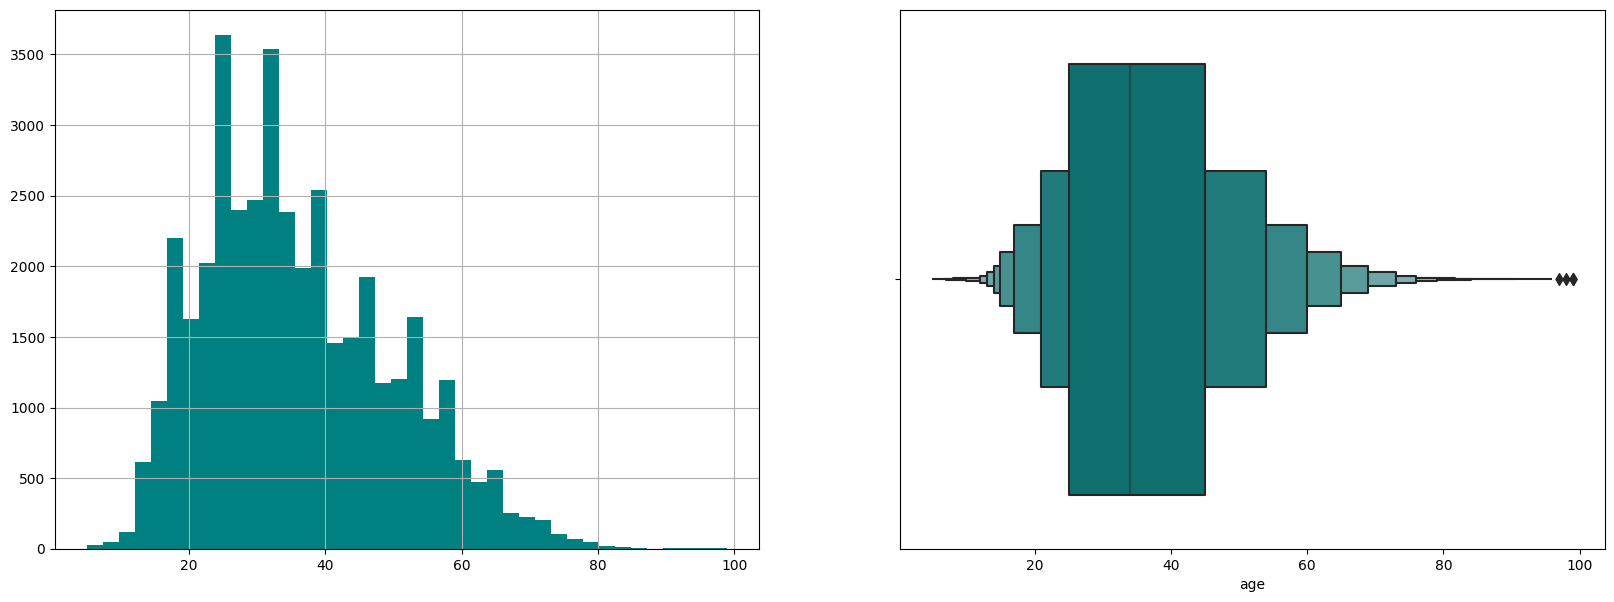

In [30]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

df_users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=df_users, x='age', color='teal',ax=ax[1])

plt.show()

In [31]:
df_users['age'].nunique()

91

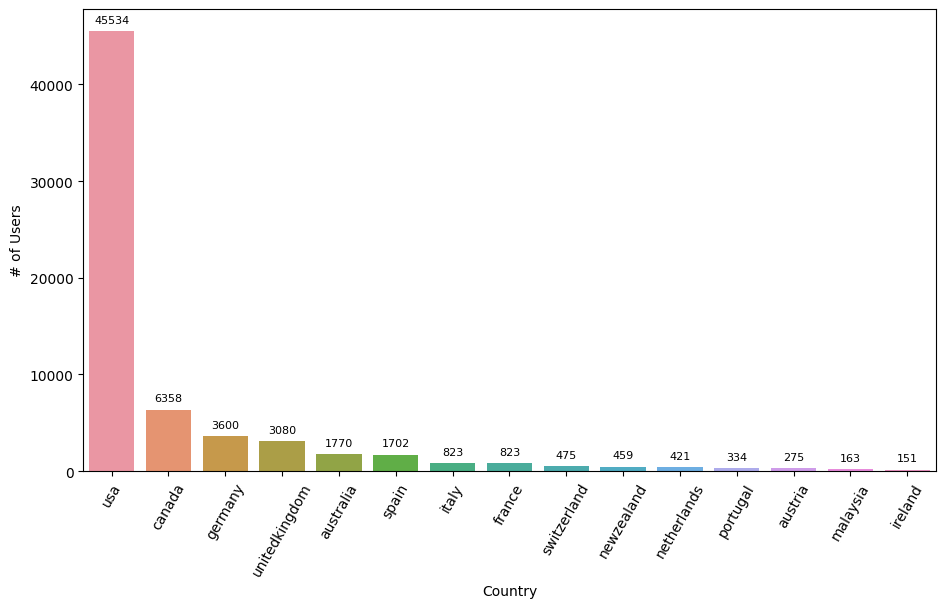

In [32]:
my_dict=(df_users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

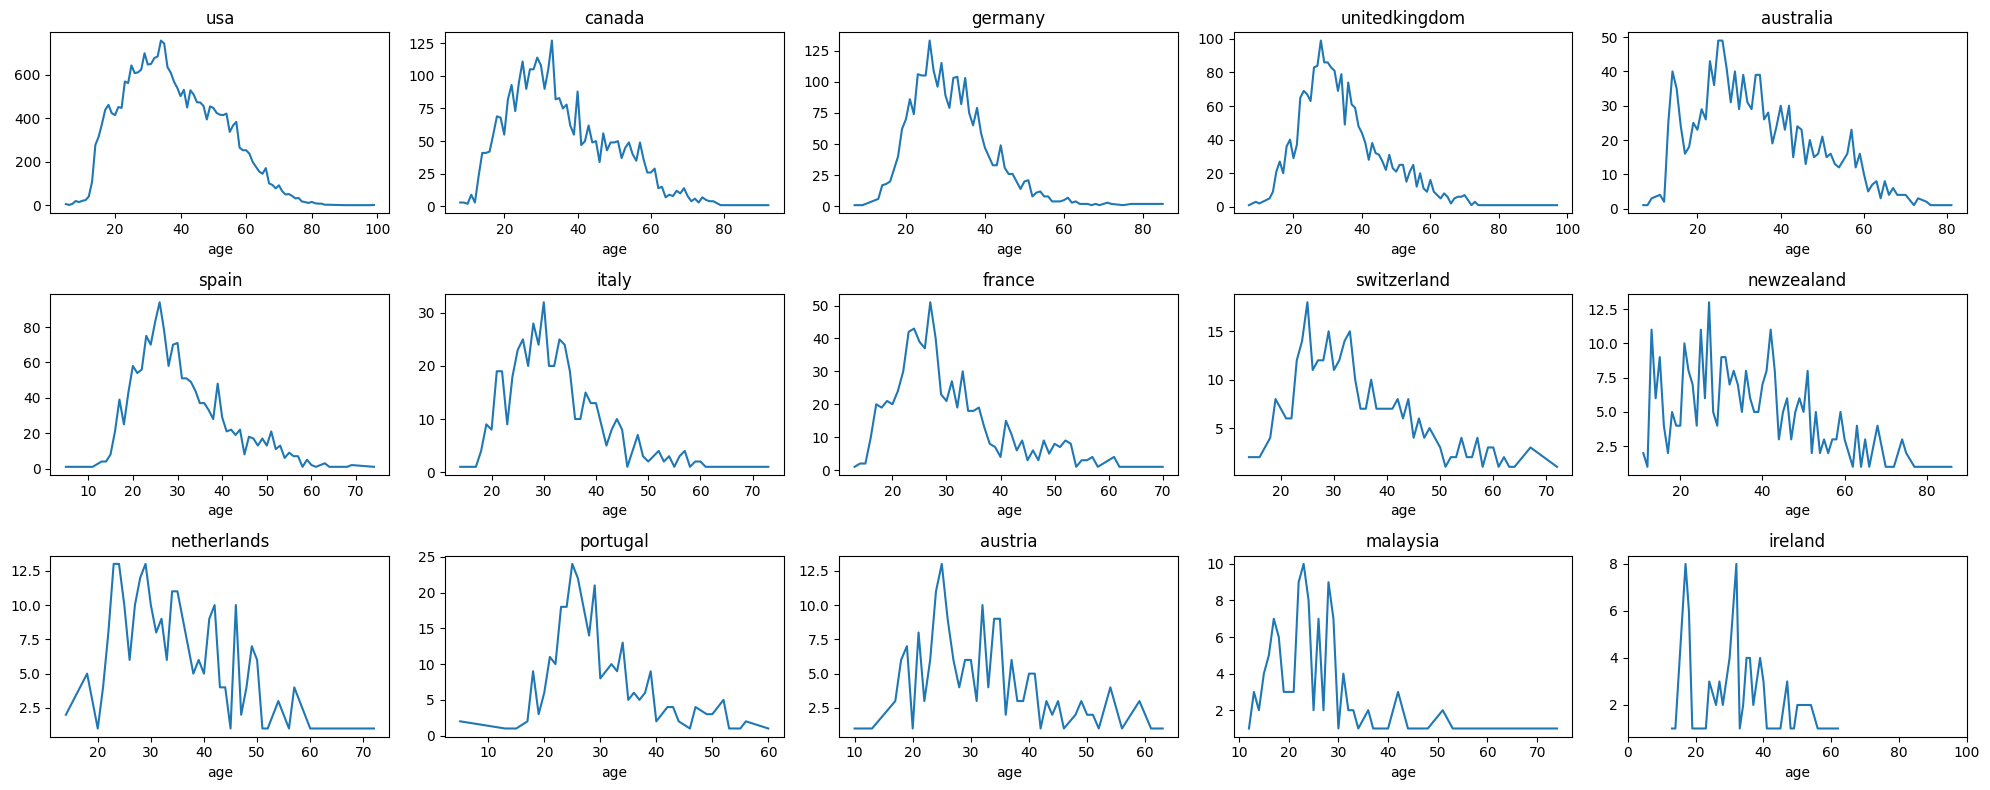

In [33]:
# 20~30대가 많으며 분포 거의 비슷
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    df_users[(df_users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

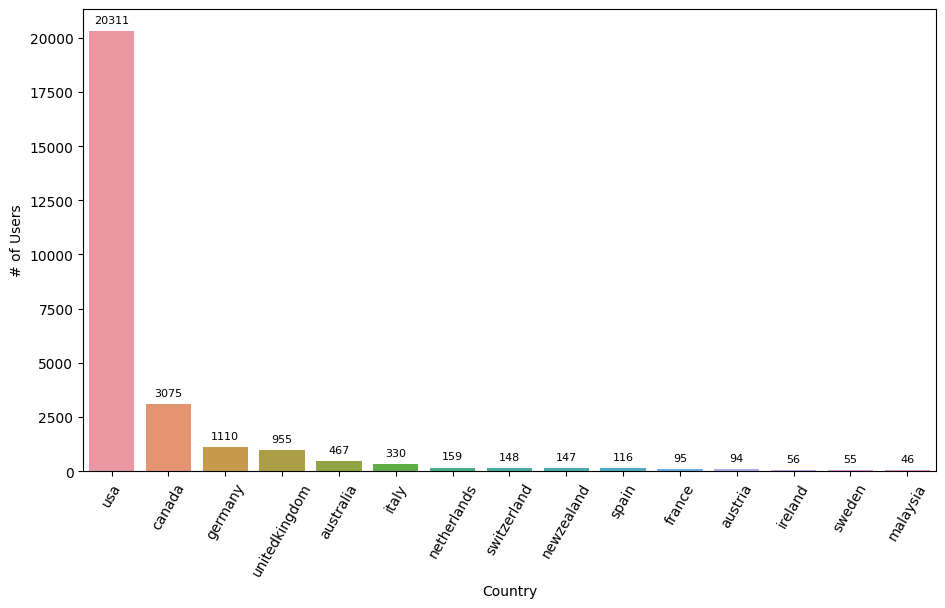

In [34]:
my_dict=(df_users[df_users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

In [35]:
def binning_age(x):
    if np.isnan(x):
        return np.nan
    
    if x < 10:
        return '0'
    
    elif 10 <= x < 20:
        return '10'
    
    elif 20 <= x < 30:
        return '20'
    
    elif 30 <= x < 40:
        return '30'
    
    elif 40 <= x < 50:
        return '40'
    
    else:
        return '50'

# def binning_age(x):
#     if np.isnan(x):
#         return np.nan
    
#     if x < 20:
#         x = 10
#     elif 20 <= x < 30:
#         x = 20
#     elif 30 <= x < 40:
#         x = 30
#     elif 40 <= x < 50:
#         x = 40
#     elif 50 <= x < 60:
#         x = 60 
#     elif x >= 60:
#         x = 60
#     return x

# df_users['binning_age'] = df_users['age'].apply(binning_age)

In [36]:
# sns.kdeplot(df_users['binning_age'])

In [37]:
# A: age:nan -> B1 -> age:B1_age
# A  age:nan -> B2 -> age:B2_age

In [38]:
temp = df_train_ratings.merge(df_users, on = 'user_id')
gia = temp.groupby('isbn')['age'].mean()
temp['gia'] = temp['isbn'].map(gia)
grouped_isbn_age_grouped_uid_gia = temp.groupby('user_id')['gia'].mean()
temp['giagua'] = temp['user_id'].map(grouped_isbn_age_grouped_uid_gia)
temp['giagua'].isna().mean()

0.01805766065287896

In [39]:
temp[temp['age'].notnull()][['age', 'giagua']].head(10)

,age,giagua
7,30.0,37.277186
8,30.0,37.277186
9,30.0,37.277186
10,30.0,37.277186
11,30.0,37.277186
12,30.0,37.277186
13,30.0,37.277186
21,60.0,48.568698
22,60.0,48.568698
23,60.0,48.568698


In [40]:
feature2index = dict(zip(temp.columns, range(len(temp.columns))))
temp['final'] = temp.apply(lambda x : x[feature2index['giagua']] if type(x[feature2index['age']]) == float and np.isnan(x[feature2index['age']]) else x[feature2index['age']], axis = 1)
uid2age = dict(zip(temp['user_id'].values, temp['final'].values))

In [41]:
df_users['age'] = df_users['user_id'].map(uid2age)
df_users['binning_age'] = df_users['age'].apply(binning_age)
# df_users['binning_age'] = df_users['binning_age'].astype('str')

In [42]:
# df_users = df_users.drop(columns='location')

In [43]:
df_users['age'].isna().mean()

0.1918140163308465

## Books

In [44]:
for column in df_books.columns:
    if column == 'isbn':
        continue
    if df_books[column].dtype == object:
        print(column)
        df_books[column] = df_books[column].apply(str_lower)

book_title
book_author
publisher
img_url
language
category
summary
img_path


In [45]:
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/p/0002005018.0...,en,['actresses'],"in a small town in canada, clara callan reluct...",images/0002005018.01.thumbzzz.jpg
1,0060973129,decision in normandy,carlo d'este,1991.0,harperperennial,http://images.amazon.com/images/p/0060973129.0...,en,['1940-1949'],"here, for the first time in paperback, is an o...",images/0060973129.01.thumbzzz.jpg
2,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999.0,farrar straus giroux,http://images.amazon.com/images/p/0374157065.0...,en,['medical'],"describes the great flu epidemic of 1918, an o...",images/0374157065.01.thumbzzz.jpg
3,0399135782,the kitchen god's wife,amy tan,1991.0,putnam pub group,http://images.amazon.com/images/p/0399135782.0...,en,['fiction'],a chinese immigrant who is convinced she is dy...,images/0399135782.01.thumbzzz.jpg
4,0425176428,what if?: the world's foremost military histor...,robert cowley,2000.0,berkley publishing group,http://images.amazon.com/images/p/0425176428.0...,en,['history'],"essays by respected military historians, inclu...",images/0425176428.01.thumbzzz.jpg


In [46]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [47]:
df_books.isna().mean()

isbn                   0.000000
book_title             0.000000
book_author            0.000007
year_of_publication    0.000000
publisher              0.000000
img_url                0.000000
language               0.449468
category               0.460326
summary                0.449468
img_path               0.000000
dtype: float64

In [48]:
df_books['publisher'].nunique()

11428

In [49]:
df_books['pnumber'] = df_books['isbn'].apply(lambda x : x[:4])

In [50]:
df_books[df_books['pnumber'] == '0140']['publisher'].value_counts()

publisher
penguin books                  1640
penguin usa                     568
penguin books ltd               430
puffin books                    401
penguin putnam~trade            118
                               ... 
select penguin                    1
hyperion books for children       1
putnam pub group                  1
virago press                      1
terra nova pr                     1
Name: count, Length: 68, dtype: int64

In [51]:
df_books['pnumber'].nunique()

1525

In [52]:
df_books[df_books['publisher']=="Penguin Books"][['publisher', 'pnumber']].head(3)

,publisher,pnumber


In [53]:
temp = df_books.groupby('publisher')['pnumber'].value_counts().groupby('publisher').idxmax().apply(lambda x : x[-1]).reset_index().rename(columns = {'count' : 'pnumber'})
publisher2pnumber = dict(zip(temp['publisher'].values, temp['pnumber'].values))

In [54]:
df_books['pnumber'] = df_books['publisher'].map(publisher2pnumber)
df_books['pnumber'].nunique()

1398

In [55]:
# df_books['pnumber'].value_counts().reset_index().groupby('count').count().reset_index().head(20)

In [56]:
# sup_pnumber = 20
# temp = df_books['pnumber'].value_counts()
# limit_pnumber = temp[temp < sup_pnumber].index

# df_books.loc[df_books['pnumber'].isin(limit_pnumber), 'pnumber'] = 'other'
# df_books['pnumber'].nunique()

In [57]:
df_books.loc[df_books[df_books['category'].notnull()].index, 'category'] = df_books[df_books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).lower().strip())

In [58]:
# 1.저자 2.출판사를 따라가지 않으까?
df_books['category'].isna().mean()

0.4603262686367587

In [59]:
temp = df_books.groupby('book_author')['category'].value_counts().groupby('book_author').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [60]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['category'] = df_books.apply(lambda x : temp[x[feature2index['book_author']]] if type(x[feature2index['category']]) == float and np.isnan(x[feature2index['category']]) else x[feature2index['category']], axis = 1)

In [61]:
df_books['category'].isna().mean()

0.17736177040850437

In [62]:
temp = df_books.groupby('pnumber')['category'].value_counts().groupby('pnumber').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [63]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['category'] = df_books.apply(lambda x : temp[x[feature2index['pnumber']]] if type(x[feature2index['category']]) == float and np.isnan(x[feature2index['category']]) else x[feature2index['category']], axis = 1)

In [64]:
df_books['category'].isna().mean()

0.003964698803235943

In [65]:
words = defaultdict(int)
for value in df_books['category'].values:
    try:
        if len(value.split()) == 1:
            words[value] += 1
    except:
        pass
print(len(words))
categories = [(value, key) for key,value in words.items()]
categories.sort(reverse = True)

1270


In [66]:
df_books['category'].value_counts()

category
fiction                                            77567
juvenile fiction                                   10696
biography autobiography                             4690
religion                                            2739
history                                             2626
                                                   ...  
icarian community                                      1
bisexuality                                            1
glasnost                                               1
asp computer network protocol                          1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [67]:
for _, category in categories:
    df_books.loc[df_books[df_books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [68]:
df_books['category_high'].isna().mean()

0.03997459383566223

In [69]:
df_books['category_high'].value_counts()

category_high
fiction          91056
autobiography     4694
science           3066
religion          2740
history           2657
                 ...  
dogsledding          1
hyperspace           1
elections            1
encarnación          1
deafness             1
Name: count, Length: 1197, dtype: int64

In [70]:
# 출판사를 따라가지 않을까?
print(df_books['language'].isna().mean())

0.449468476298723


In [71]:
temp = df_books.groupby('pnumber')['language'].value_counts().groupby('pnumber').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [72]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['language'] = df_books.apply(lambda x : temp[x[feature2index['pnumber']]] if type(x[feature2index['language']]) == float and np.isnan(x[feature2index['language']]) else x[feature2index['language']], axis = 1)

In [73]:
print(df_books['language'].isna().mean())

0.007347730159791402


In [74]:
# en vs else

<Axes: xlabel='year_of_publication', ylabel='Density'>

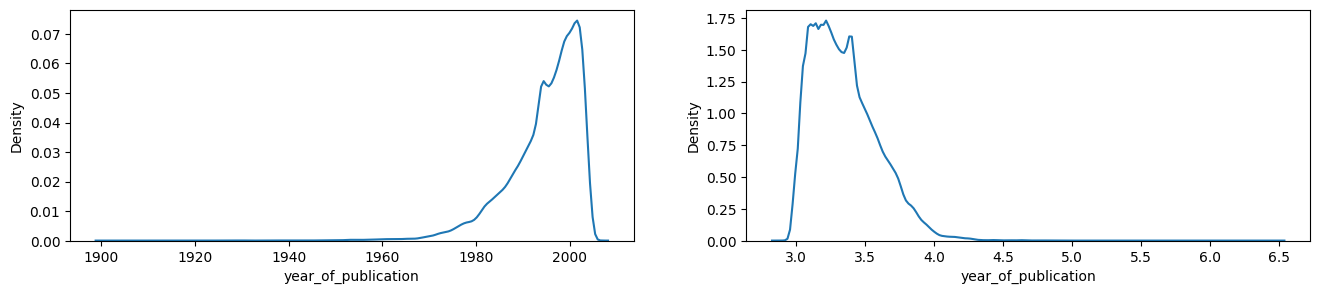

In [75]:
# 1. 현재(2023)부터 얼마나 오래된 책인지, 2. log transform을 통해 sknewss 완화 3. 오랜된 책은 한번에 묶어주기(Binning)
f, ax = plt.subplots(1,2, figsize = (16, 3))

sns.kdeplot(df_books[df_books['year_of_publication'] > 1900]['year_of_publication'], ax = ax[0])
sns.kdeplot(df_books['year_of_publication'].apply(lambda x : np.log1p(2023 - x)), ax = ax[1])

0.6522555632345214


<Axes: xlabel='log_year_of_publication', ylabel='Density'>

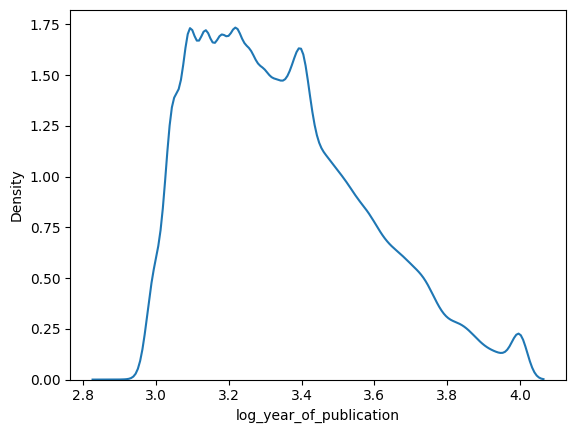

In [76]:
sup = 4

df_books['log_year_of_publication'] = df_books['year_of_publication'].apply(lambda x : np.log1p(2023 - x))
df_books['log_year_of_publication'] = df_books['log_year_of_publication'].apply(lambda x : x if x < sup else sup)

print(df_books['log_year_of_publication'].skew())
sns.kdeplot(df_books['log_year_of_publication'])

In [77]:
def binning_year(x):
    if x < 1970:
        return '1970'
    elif 1970 <= x < 1980:
        return '1980'
    elif 1980 <= x < 1990:
        return '1990'
    elif 1990 <= x < 2000:
        return '2000'
    else:
        return 'Early'
    
df_books['binning_year'] = df_books['year_of_publication'].apply(binning_year)

In [78]:
df_books['book_title'].value_counts()

book_title
the secret garden                                        19
selected poems                                           16
little women                                             16
dracula                                                  16
adventures of huckleberry finn                           15
                                                         ..
graceland : a novel                                       1
another world                                             1
tiden det tar: roman                                      1
a folk weather calendar (what will the weather be, 1)     1
dallas street map guide and directory, 2000 edition       1
Name: count, Length: 134011, dtype: int64

In [79]:
# Frances Hodgson Burnett
# Frances H. Burnett

In [80]:
df_books[df_books['book_title'] == 'the secret garden']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,pnumber,category_high,log_year_of_publication,binning_year
5098,0812505018,the secret garden,frances hodgson burnett,1989.0,tor books,http://images.amazon.com/images/p/0812505018.0...,en,fiction,"an orphan, sent from india to england to live ...",images/0812505018.01.thumbzzz.jpg,0812,fiction,3.555348,1990
11516,0590433466,the secret garden,frances h. burnett,1997.0,scholastic,http://images.amazon.com/images/p/0590433466.0...,en,juvenile fiction,NaN,images/0590433466.01.thumbzzz.jpg,0590,fiction,3.295837,2000
13601,006440188X,the secret garden,frances hodgson burnett,1998.0,harpertrophy,http://images.amazon.com/images/p/006440188x.0...,en,juvenile fiction,&quot;one of th&#39; gardens is locked up.,images/006440188x.01.thumbzzz.jpg,0064,fiction,3.258097,2000
20350,0440977096,the secret garden,frances hodgson burnett,1989.0,laure leaf,http://images.amazon.com/images/p/0440977096.0...,en,juvenile fiction,ten-year-old mary comes to live in a lonely ho...,images/0440977096.01.thumbzzz.jpg,0440,fiction,3.555348,1990
22930,0879236493,the secret garden,frances hodgson burnett,1987.0,david r. godine publisher,http://images.amazon.com/images/p/0879236493.0...,en,juvenile fiction,the robin helps mary find the door to the secr...,images/0879236493.01.thumbzzz.jpg,0879,fiction,3.610918,1990
37322,0590471724,the secret garden,m.j. carr,1993.0,scholastic paperbacks (mm),http://images.amazon.com/images/p/0590471724.0...,en,gardens,a young orphan discovers a whole new world whe...,images/0590471724.01.thumbzzz.jpg,0590,gardens,3.433987,2000
51248,055321201X,the secret garden,frances h. burnett,1987.0,bantam,http://images.amazon.com/images/p/055321201x.0...,en,juvenile fiction,ten-year-old mary comes to live in a lonely ho...,images/055321201x.01.thumbzzz.jpg,0553,fiction,3.610918,1990
51414,0439099390,the secret garden,frances hodgson burnett,1999.0,scholastic,http://images.amazon.com/images/p/0439099390.0...,en,juvenile fiction,a ten-year-old orphan comes to live in a lonel...,images/0439099390.01.thumbzzz.jpg,0590,fiction,3.218876,2000
55931,0440777062,the secret garden,frances hodgson burnett,1979.0,dell publishing,http://images.amazon.com/images/p/0440777062.0...,en,children with disabilities,ten-year-old mary comes to live in a lonely ho...,images/0440777062.01.thumbzzz.jpg,0440,children,3.806662,1980
59407,0397306326,the secret garden,frances hodgson burnett,1985.0,lippincott,http://images.amazon.com/images/p/0397306326.0...,en,children with disabilities,ten-year-old mary comes to live in a lonely ho...,images/0397306326.01.thumbzzz.jpg,0397,children,3.663562,1990


In [81]:
df_users.isna().mean()

user_id             0.000000
location            0.000000
age                 0.191814
location_city       0.001894
location_state      0.007945
location_country    0.004259
binning_age         0.191814
dtype: float64

In [82]:
df_books.isna().mean()

isbn                       0.000000
book_title                 0.000000
book_author                0.000007
year_of_publication        0.000000
publisher                  0.000000
img_url                    0.000000
language                   0.007348
category                   0.003965
summary                    0.449468
img_path                   0.000000
pnumber                    0.000000
category_high              0.039975
log_year_of_publication    0.000000
binning_year               0.000000
dtype: float64

(0.0, 11.0)

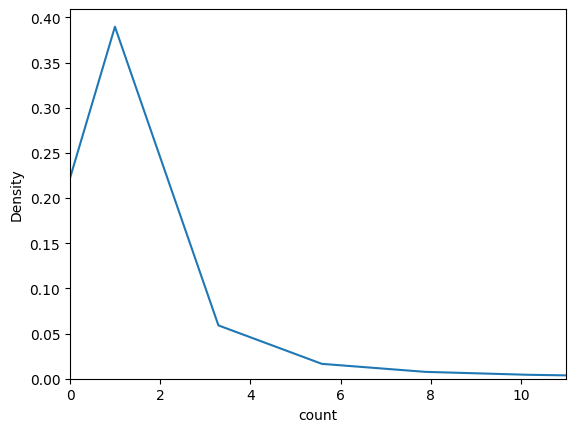

In [83]:
sns.kdeplot(df_books['book_author'].value_counts())
plt.xlim([0,11])

In [84]:
# sup_author = 3
# temp = df_books['book_author'].value_counts()
# limit_author = temp[temp < sup_author].index
# df_books.loc[df_books['book_author'].isin(limit_author), 'book_author'] = 'other'
# print(df_books['book_author'].nunique() / len(df_books))

In [85]:
temp = df_train_ratings.merge(df_books, how='left', on='isbn')
data = temp.merge(df_users, how='left', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 22)


In [86]:
data.isna().mean()

user_id                    0.000000
isbn                       0.000000
rating                     0.000000
book_title                 0.000000
book_author                0.000003
year_of_publication        0.000000
publisher                  0.000000
img_url                    0.000000
language                   0.003266
category                   0.001747
summary                    0.388155
img_path                   0.000000
pnumber                    0.000000
category_high              0.026379
log_year_of_publication    0.000000
binning_year               0.000000
location                   0.000000
age                        0.018058
location_city              0.022878
location_state             0.026461
location_country           0.025180
binning_age                0.018058
dtype: float64

In [87]:
data.nunique() / len(data)

user_id                    0.194928
isbn                       0.423009
rating                     0.000033
book_title                 0.379853
book_author                0.173028
year_of_publication        0.000300
publisher                  0.033491
img_url                    0.423009
language                   0.000078
category                   0.012314
summary                    0.228319
img_path                   0.423009
pnumber                    0.004345
category_high              0.003719
log_year_of_publication    0.000121
binning_year               0.000016
location                   0.053899
age                        0.024098
location_city              0.036174
location_state             0.003178
location_country           0.000610
binning_age                0.000020
dtype: float64

In [88]:
# temp = data['user_id'].value_counts()
# removed = temp[temp == 1].index
# data = data[~(data['user_id'].isin(removed))]

In [89]:
rating_var = data.groupby('user_id')['rating'].var().rename('rating_var')
data = data.merge(rating_var, on = 'user_id')
data['rating_var'].fillna(value = 0.0, inplace = True)

data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title']]
# data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title', 'rating_var']]

data['book_author'] = data['book_author'].fillna(value = 'other')
data['language'] = data['language'].fillna(value = 'other')
data['binning_year'] = data['binning_year'].fillna(value = 'other')
data['category_high'] = data['category_high'].fillna(value = 'other')
data['binning_age'] = data['binning_age'].fillna(value = 'other')
data['location_city'] = data['location_city'].fillna(value = 'other')
data['location_state'] = data['location_state'].fillna(value = 'other')
data['location_country'] = data['location_country'].fillna(value = 'other')
data['book_title'] = data['book_title'].fillna(value = 'other')

In [90]:
X = data.drop('rating', axis = 1)
categorical_features_indices = np.where(X.dtypes == object)[0]
print(categorical_features_indices)
y = data['rating']

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [91]:
path = '.'
data_path = path + '/data'
sample_submission_path = data_path + '/sample_submission.csv'

In [92]:
df_sample_submission = pd.read_csv(sample_submission_path)
df_sample_submission['user_id'] = df_sample_submission['user_id'].astype(str)

In [93]:
df_sample_submission.head()

,user_id,isbn,rating
0,11676,0002005018,0
1,116866,0002005018,0
2,152827,0060973129,0
3,157969,0374157065,0
4,67958,0399135782,0


In [94]:
temp = df_sample_submission.merge(df_books, how='left', on='isbn')
test = temp.merge(df_users, how='left', on='user_id')
print('merge 결과 shape: ', test.shape)
test.head()

merge 결과 shape:  (76699, 22)


,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,...,pnumber,category_high,log_year_of_publication,binning_year,location,age,location_city,location_state,location_country,binning_age
0,11676,0002005018,0,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/p/0002005018.0...,en,actresses,...,0002,actresses,3.135494,Early,"na,na,na",37.347285,NaN,NaN,NaN,30
1,116866,0002005018,0,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/p/0002005018.0...,en,actresses,...,0002,actresses,3.135494,Early,"ottawa,,",40.833523,ottawa,ontario,canada,40
2,152827,0060973129,0,decision in normandy,carlo d'este,1991.0,harperperennial,http://images.amazon.com/images/p/0060973129.0...,en,1940 1949,...,0006,0,3.496508,2000,"ottawa,ontario,canada",40.000000,ottawa,ontario,canada,40
3,157969,0374157065,0,flu: the story of the great influenza pandemic...,gina bari kolata,1999.0,farrar straus giroux,http://images.amazon.com/images/p/0374157065.0...,en,medical,...,0374,medical,3.218876,2000,"denver,colorado,usa",30.000000,denver,colorado,usa,30
4,67958,0399135782,0,the kitchen god's wife,amy tan,1991.0,putnam pub group,http://images.amazon.com/images/p/0399135782.0...,en,fiction,...,0399,fiction,3.496508,2000,"idahofalls,idaho,usa",39.000000,idahofalls,idaho,usa,30


In [95]:
test = test.merge(rating_var, how='left', on = 'user_id')
test['rating_var'].fillna(value = 0.0, inplace = True)

test= test[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title']]
# data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title', 'rating_var']]

test['book_author'] = test['book_author'].fillna(value = 'other')
test['language'] = test['language'].fillna(value = 'other')
test['binning_year'] = test['binning_year'].fillna(value = 'other')
test['category_high'] = test['category_high'].fillna(value = 'other')
test['binning_age'] = test['binning_age'].fillna(value = 'other')
test['location_city'] = test['location_city'].fillna(value = 'other')
test['location_state'] = test['location_state'].fillna(value = 'other')
test['location_country'] = test['location_country'].fillna(value = 'other')
test['book_title'] = test['book_title'].fillna(value = 'other')

test = test.drop('rating', axis = 1)

In [96]:
def rmse(y, y_pred):
    return mean_squared_error(y, y_pred, squared = False)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

folds = []
for train_idx, valid_idx in cv.split(X, y):
    folds.append((train_idx,valid_idx))

def objective(trial):
    param = {
        "random_state" : seed,
        "objective" : "RMSE",
        "cat_features" : categorical_features_indices,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=500
    )

    cat_pred = model.predict(X_valid)
    score = rmse(y_valid, cat_pred)

    return score

for fold in range(0, n_splits):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler)
    
    study.optimize(objective, n_trials=10)

    print('best params {} :'.format(fold+1), study.best_params)
    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', devices = '0', 
                          random_state = seed, objective = 'RMSE', cat_features = categorical_features_indices)
    model.fit(X_train, y_train, verbose=500)
                
    pred = model.predict(test)
    df_sample_submission[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

[I 2023-04-18 15:07:57,781] A new study created in memory with name: cat_parameter_opt


====================================1============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4327008	test: 2.4326681	best: 2.4326681 (0)	total: 16.3ms	remaining: 2m 3s
bestTest = 2.425869228
bestIteration = 224
Shrink model to first 225 iterations.


[I 2023-04-18 15:08:04,079] Trial 0 finished with value: 2.425869331453869 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425869331453869.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4330797	test: 2.4330967	best: 2.4330967 (0)	total: 13.7ms	remaining: 1m 56s
500:	learn: 2.4272033	test: 2.4258743	best: 2.4258743 (500)	total: 6.33s	remaining: 1m 40s
1000:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 12.7s	remaining: 1m 34s
1500:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 19s	remaining: 1m 28s
2000:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 25.3s	remaining: 1m 22s
2500:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 31.6s	remaining: 1m 15s
3000:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 38s	remaining: 1m 9s
3500:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 44.3s	remaining: 1m 3s
4000:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 50.7s	remaining: 56.9s
4500:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 57s	remaining: 50.5s
5000:	learn: 2.4272032	test: 2.4258694	best: 2.4258694 (763)	total: 1m 3s	remaining: 44.1s
5500

[I 2023-04-18 15:09:54,061] Trial 1 finished with value: 2.425869558975217 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.425869331453869.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4033111	test: 2.3986449	best: 2.3986449 (0)	total: 31.1ms	remaining: 1m 52s
500:	learn: 2.1142829	test: 2.1276384	best: 2.1275254 (480)	total: 13.4s	remaining: 1m 23s
1000:	learn: 2.0583478	test: 2.1280101	best: 2.1274530 (533)	total: 26s	remaining: 1m 8s
1500:	learn: 2.0093240	test: 2.1297834	best: 2.1274530 (533)	total: 39.4s	remaining: 55.8s
2000:	learn: 1.9646834	test: 2.1334613	best: 2.1274530 (533)	total: 52.8s	remaining: 43s
2500:	learn: 1.9246816	test: 2.1367317	best: 2.1274530 (533)	total: 1m 6s	remaining: 30s
3000:	learn: 1.8851992	test: 2.1392736	best: 2.1274530 (533)	total: 1m 19s	remaining: 16.7s
3500:	learn: 1.8495835	test: 2.1425594	best: 2.1274530 (533)	total: 1m 33s	remaining: 3.4s
3628:	learn: 1.8401869	test: 2.1435566	best: 2.1274530 (533)	total: 1m 36s	remaining: 0us
bestTest = 2.127453
bestIteration = 533
Shrink model to first 534 iterations.


[I 2023-04-18 15:11:33,937] Trial 2 finished with value: 2.1274530296312704 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1274530296312704.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4036533	test: 2.4037401	best: 2.4037401 (0)	total: 463ms	remaining: 12m 13s
500:	learn: 0.7570557	test: 2.2071918	best: 2.1375898 (135)	total: 3m 51s	remaining: 8m 20s
1000:	learn: 0.3520869	test: 2.2310727	best: 2.1375898 (135)	total: 7m 42s	remaining: 4m 29s
1500:	learn: 0.2010767	test: 2.2379231	best: 2.1375898 (135)	total: 11m 30s	remaining: 38.6s
1584:	learn: 0.1881735	test: 2.2385419	best: 2.1375898 (135)	total: 12m 8s	remaining: 0us
bestTest = 2.137589847
bestIteration = 135
Shrink model to first 136 iterations.


[I 2023-04-18 15:23:47,280] Trial 3 finished with value: 2.1375897961315555 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1274530296312704.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.4271707	test: 2.4266238	best: 2.4266238 (0)	total: 247ms	remaining: 5m 23s
500:	learn: 2.0283235	test: 2.1320566	best: 2.1320566 (500)	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8411562	test: 2.1262732	best: 2.1262447 (979)	total: 4m 9s	remaining: 1m 16s
1308:	learn: 1.6411182	test: 2.1302514	best: 2.1262447 (979)	total: 5m 27s	remaining: 0us
bestTest = 2.126244698
bestIteration = 979
Shrink model to first 980 iterations.


[I 2023-04-18 15:29:23,097] Trial 4 finished with value: 2.1262447097592476 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1262447097592476.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3659411	test: 2.3838877	best: 2.3838877 (0)	total: 254ms	remaining: 39m 57s
bestTest = 2.289988966
bestIteration = 21
Shrink model to first 22 iterations.


[I 2023-04-18 15:29:35,816] Trial 5 finished with value: 2.2899889484431464 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1262447097592476.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4194270	test: 2.4168117	best: 2.4168117 (0)	total: 30.7ms	remaining: 4m 19s
500:	learn: 2.1542242	test: 2.1290055	best: 2.1289953 (498)	total: 13.4s	remaining: 3m 33s
bestTest = 2.127774475
bestIteration = 613
Shrink model to first 614 iterations.


[I 2023-04-18 15:29:56,356] Trial 6 finished with value: 2.1277742695832487 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1262447097592476.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.3686150	test: 2.3608859	best: 2.3608859 (0)	total: 141ms	remaining: 2m 28s
500:	learn: 0.8434140	test: 2.2564818	best: 2.1445904 (54)	total: 1m 10s	remaining: 1m 17s
1000:	learn: 0.4153277	test: 2.2902841	best: 2.1445904 (54)	total: 2m 20s	remaining: 6.75s
1048:	learn: 0.3938850	test: 2.2917911	best: 2.1445904 (54)	total: 2m 27s	remaining: 0us
bestTest = 2.144590439
bestIteration = 54
Shrink model to first 55 iterations.


[I 2023-04-18 15:32:27,017] Trial 7 finished with value: 2.144590362432992 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1262447097592476.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.3681838	test: 2.3599725	best: 2.3599725 (0)	total: 13.7ms	remaining: 54.3s
500:	learn: 2.1833470	test: 2.1469303	best: 2.1468472 (479)	total: 8.15s	remaining: 56.6s
1000:	learn: 2.1718580	test: 2.1448488	best: 2.1447444 (935)	total: 16.2s	remaining: 48.2s
1500:	learn: 2.1629312	test: 2.1447137	best: 2.1445400 (1229)	total: 24.2s	remaining: 39.9s
2000:	learn: 2.1550073	test: 2.1441488	best: 2.1438510 (1793)	total: 32.2s	remaining: 31.9s
2500:	learn: 2.1473913	test: 2.1447214	best: 2.1438510 (1793)	total: 40.3s	remaining: 23.8s
3000:	learn: 2.1410909	test: 2.1454162	best: 2.1438510 (1793)	total: 48.4s	remaining: 15.8s
3500:	learn: 2.1352868	test: 2.1457928	best: 2.1438510 (1793)	total: 56.5s	remaining: 7.7s
3977:	learn: 2.1298819	test: 2.1468148	best: 2.1438510 (1793)	total: 1m 4s	remaining: 0us
bestTest = 2.143851048
bestIteration = 1793
Shrink model to first 1794 iterations.


[I 2023-04-18 15:33:33,971] Trial 8 finished with value: 2.1438510810704137 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1262447097592476.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4301826	test: 2.4301169	best: 2.4301169 (0)	total: 41.8ms	remaining: 5m 27s
500:	learn: 2.1698965	test: 2.2004839	best: 2.2004839 (500)	total: 20.8s	remaining: 5m 4s
1000:	learn: 2.1038712	test: 2.1830688	best: 2.1830688 (1000)	total: 41.6s	remaining: 4m 44s
1500:	learn: 2.0545680	test: 2.1767014	best: 2.1767014 (1500)	total: 1m 3s	remaining: 4m 26s
bestTest = 2.175823746
bestIteration = 1591
Shrink model to first 1592 iterations.


[I 2023-04-18 15:34:44,736] Trial 9 finished with value: 2.175823667020074 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1262447097592476.


best params 1 : {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
0:	learn: 2.4271707	total: 248ms	remaining: 5m 24s
500:	learn: 2.0283862	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8386054	total: 4m 6s	remaining: 1m 15s
1308:	learn: 1.6480913	total: 5m 22s	remaining: 0us


[I 2023-04-18 15:40:17,588] A new study created in memory with name: cat_parameter_opt




====================================2============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4326838	test: 2.4327309	best: 2.4327309 (0)	total: 14.4ms	remaining: 1m 49s
bestTest = 2.42676551
bestIteration = 163
Shrink model to first 164 iterations.


[I 2023-04-18 15:40:22,549] Trial 0 finished with value: 2.4267656365424664 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4267656365424664.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330729	test: 2.4331367	best: 2.4331367 (0)	total: 14.4ms	remaining: 2m 2s
500:	learn: 2.4270322	test: 2.4267665	best: 2.4267663 (490)	total: 6.59s	remaining: 1m 45s
1000:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 13.2s	remaining: 1m 38s
1500:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 19.8s	remaining: 1m 32s
2000:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 26.5s	remaining: 1m 26s
2500:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 33.2s	remaining: 1m 19s
3000:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 39.7s	remaining: 1m 12s
3500:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 46.3s	remaining: 1m 6s
4000:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 53.1s	remaining: 59.6s
4500:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 59.7s	remaining: 52.9s
5000:	learn: 2.4270317	test: 2.4267654	best: 2.4267654 (812)	total: 1m 6s	remaining: 46.4

[I 2023-04-18 15:42:20,073] Trial 1 finished with value: 2.426765530211945 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426765530211945.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4031836	test: 2.3996362	best: 2.3996362 (0)	total: 28.7ms	remaining: 1m 44s
500:	learn: 2.1169222	test: 2.1388604	best: 2.1385212 (461)	total: 12.4s	remaining: 1m 17s
1000:	learn: 2.0637255	test: 2.1392444	best: 2.1385212 (461)	total: 24.8s	remaining: 1m 5s
1500:	learn: 2.0170746	test: 2.1413383	best: 2.1385212 (461)	total: 37.1s	remaining: 52.6s
2000:	learn: 1.9726692	test: 2.1443794	best: 2.1385212 (461)	total: 49.4s	remaining: 40.2s
2500:	learn: 1.9316967	test: 2.1467363	best: 2.1385212 (461)	total: 1m 1s	remaining: 27.8s
3000:	learn: 1.8942919	test: 2.1491933	best: 2.1385212 (461)	total: 1m 13s	remaining: 15.5s
3500:	learn: 1.8602061	test: 2.1510660	best: 2.1385212 (461)	total: 1m 26s	remaining: 3.16s
3628:	learn: 1.8516577	test: 2.1512442	best: 2.1385212 (461)	total: 1m 29s	remaining: 0us
bestTest = 2.138521218
bestIteration = 461
Shrink model to first 462 iterations.


[I 2023-04-18 15:43:53,070] Trial 2 finished with value: 2.138521160809534 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.138521160809534.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4031213	test: 2.4036373	best: 2.4036373 (0)	total: 464ms	remaining: 12m 15s
500:	learn: 0.8250432	test: 2.1995612	best: 2.1498368 (159)	total: 3m 51s	remaining: 8m 20s
1000:	learn: 0.3973001	test: 2.2212879	best: 2.1498368 (159)	total: 7m 40s	remaining: 4m 28s
1500:	learn: 0.2230699	test: 2.2287901	best: 2.1498368 (159)	total: 11m 29s	remaining: 38.6s
1584:	learn: 0.2061285	test: 2.2296676	best: 2.1498368 (159)	total: 12m 7s	remaining: 0us
bestTest = 2.149836761
bestIteration = 159
Shrink model to first 160 iterations.


[I 2023-04-18 15:56:06,002] Trial 3 finished with value: 2.1498367165634704 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.138521160809534.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4268645	test: 2.4266649	best: 2.4266649 (0)	total: 250ms	remaining: 5m 26s
500:	learn: 2.0232895	test: 2.1425484	best: 2.1425484 (500)	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8377942	test: 2.1372231	best: 2.1371365 (985)	total: 4m 8s	remaining: 1m 16s
1308:	learn: 1.6515788	test: 2.1390112	best: 2.1371365 (985)	total: 5m 26s	remaining: 0us
bestTest = 2.137136521
bestIteration = 985
Shrink model to first 986 iterations.


[I 2023-04-18 16:01:40,818] Trial 4 finished with value: 2.137136537865844 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.137136537865844.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.3494632	test: 2.3573851	best: 2.3573851 (0)	total: 243ms	remaining: 38m 19s
bestTest = 2.27094791
bestIteration = 14
Shrink model to first 15 iterations.


[I 2023-04-18 16:01:51,880] Trial 5 finished with value: 2.2709479158481223 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.137136537865844.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4195325	test: 2.4171422	best: 2.4171422 (0)	total: 30ms	remaining: 4m 13s
500:	learn: 2.1559750	test: 2.1404660	best: 2.1404660 (500)	total: 12.9s	remaining: 3m 25s
bestTest = 2.13801497
bestIteration = 786
Shrink model to first 787 iterations.


[I 2023-04-18 16:02:15,707] Trial 6 finished with value: 2.1380148690440177 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.137136537865844.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.3683537	test: 2.3624319	best: 2.3624319 (0)	total: 141ms	remaining: 2m 28s
500:	learn: 0.8936397	test: 2.2461764	best: 2.1529155 (74)	total: 1m 11s	remaining: 1m 17s
1000:	learn: 0.4601201	test: 2.2761492	best: 2.1529155 (74)	total: 2m 21s	remaining: 6.77s
1048:	learn: 0.4356975	test: 2.2773714	best: 2.1529155 (74)	total: 2m 27s	remaining: 0us
bestTest = 2.152915517
bestIteration = 74
Shrink model to first 75 iterations.


[I 2023-04-18 16:04:46,887] Trial 7 finished with value: 2.15291556102906 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.137136537865844.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.3715860	test: 2.3635826	best: 2.3635826 (0)	total: 14.5ms	remaining: 57.5s
500:	learn: 2.1848099	test: 2.1592617	best: 2.1591212 (484)	total: 8.7s	remaining: 1m
1000:	learn: 2.1736430	test: 2.1562544	best: 2.1561962 (998)	total: 17.1s	remaining: 50.9s
1500:	learn: 2.1646928	test: 2.1547840	best: 2.1546478 (1490)	total: 25s	remaining: 41.2s
2000:	learn: 2.1567522	test: 2.1531579	best: 2.1530197 (1794)	total: 33.3s	remaining: 32.9s
2500:	learn: 2.1495529	test: 2.1529127	best: 2.1528539 (2456)	total: 41.8s	remaining: 24.7s
3000:	learn: 2.1425170	test: 2.1525756	best: 2.1520760 (2803)	total: 49.8s	remaining: 16.2s
3500:	learn: 2.1362667	test: 2.1524322	best: 2.1520255 (3169)	total: 57.6s	remaining: 7.85s
3977:	learn: 2.1310043	test: 2.1526241	best: 2.1520255 (3169)	total: 1m 5s	remaining: 0us
bestTest = 2.15202552
bestIteration = 3169
Shrink model to first 3170 iterations.


[I 2023-04-18 16:05:54,905] Trial 8 finished with value: 2.1520255114732607 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.137136537865844.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4294809	test: 2.4293119	best: 2.4293119 (0)	total: 42.8ms	remaining: 5m 36s
500:	learn: 2.1683095	test: 2.2073725	best: 2.2073532 (499)	total: 20.8s	remaining: 5m 4s
1000:	learn: 2.1054929	test: 2.1930885	best: 2.1930860 (999)	total: 41.3s	remaining: 4m 42s
bestTest = 2.189638552
bestIteration = 1210
Shrink model to first 1211 iterations.


[I 2023-04-18 16:06:49,262] Trial 9 finished with value: 2.1896384375244202 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.137136537865844.


best params 2 : {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
0:	learn: 2.4268645	total: 247ms	remaining: 5m 22s
500:	learn: 2.0238595	total: 2m 2s	remaining: 3m 17s
1000:	learn: 1.8375088	total: 4m 5s	remaining: 1m 15s
1308:	learn: 1.6537637	total: 5m 22s	remaining: 0us


[I 2023-04-18 16:12:21,513] A new study created in memory with name: cat_parameter_opt




====================================3============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4326983	test: 2.4327397	best: 2.4327397 (0)	total: 14.2ms	remaining: 1m 47s
bestTest = 2.426785867
bestIteration = 153
Shrink model to first 154 iterations.


[I 2023-04-18 16:12:26,316] Trial 0 finished with value: 2.426786045575834 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426786045575834.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4330766	test: 2.4331389	best: 2.4331389 (0)	total: 14.8ms	remaining: 2m 5s
500:	learn: 2.4272061	test: 2.4267871	best: 2.4267870 (499)	total: 6.86s	remaining: 1m 49s
1000:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 13.8s	remaining: 1m 43s
1500:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 20.7s	remaining: 1m 36s
2000:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 27.6s	remaining: 1m 29s
2500:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 34.5s	remaining: 1m 22s
3000:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 41.6s	remaining: 1m 16s
3500:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 48.7s	remaining: 1m 9s
4000:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 55.7s	remaining: 1m 2s
4500:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 1m 2s	remaining: 55.7s
5000:	learn: 2.4272064	test: 2.4267857	best: 2.4267856 (747)	total: 1m 9s	remaining: 48.5

[I 2023-04-18 16:14:24,883] Trial 1 finished with value: 2.426785836229996 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426785836229996.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4026822	test: 2.3974682	best: 2.3974682 (0)	total: 29.9ms	remaining: 1m 48s
500:	learn: 2.1159954	test: 2.1268342	best: 2.1268024 (486)	total: 13.1s	remaining: 1m 21s
1000:	learn: 2.0612496	test: 2.1254836	best: 2.1252764 (908)	total: 26.2s	remaining: 1m 8s
1500:	learn: 2.0119974	test: 2.1259926	best: 2.1246831 (1229)	total: 39.2s	remaining: 55.5s
2000:	learn: 1.9683453	test: 2.1274724	best: 2.1246831 (1229)	total: 51.6s	remaining: 42s
2500:	learn: 1.9273914	test: 2.1300885	best: 2.1246831 (1229)	total: 1m 4s	remaining: 28.9s
3000:	learn: 1.8881240	test: 2.1329158	best: 2.1246831 (1229)	total: 1m 17s	remaining: 16.3s
3500:	learn: 1.8509395	test: 2.1352260	best: 2.1246831 (1229)	total: 1m 31s	remaining: 3.34s
3628:	learn: 1.8421082	test: 2.1364787	best: 2.1246831 (1229)	total: 1m 34s	remaining: 0us
bestTest = 2.124683138
bestIteration = 1229
Shrink model to first 1230 iterations.


[I 2023-04-18 16:16:03,320] Trial 2 finished with value: 2.12468307390064 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.4034828	test: 2.4036451	best: 2.4036451 (0)	total: 461ms	remaining: 12m 9s
500:	learn: 0.7462287	test: 2.2090769	best: 2.1399738 (142)	total: 3m 51s	remaining: 8m 21s
1000:	learn: 0.3498839	test: 2.2330624	best: 2.1399738 (142)	total: 7m 42s	remaining: 4m 29s
1500:	learn: 0.2070303	test: 2.2401224	best: 2.1399738 (142)	total: 11m 31s	remaining: 38.7s
1584:	learn: 0.1915924	test: 2.2407510	best: 2.1399738 (142)	total: 12m 9s	remaining: 0us
bestTest = 2.139973799
bestIteration = 142
Shrink model to first 143 iterations.


[I 2023-04-18 16:28:18,069] Trial 3 finished with value: 2.1399736173865054 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4272421	test: 2.4265917	best: 2.4265917 (0)	total: 245ms	remaining: 5m 20s
500:	learn: 2.0330187	test: 2.1330115	best: 2.1330017 (499)	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8369337	test: 2.1278469	best: 2.1277346 (956)	total: 4m 7s	remaining: 1m 16s
1308:	learn: 1.6331143	test: 2.1319608	best: 2.1277346 (956)	total: 5m 24s	remaining: 0us
bestTest = 2.127734623
bestIteration = 956
Shrink model to first 957 iterations.


[I 2023-04-18 16:33:50,904] Trial 4 finished with value: 2.127734592303354 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.3713449	test: 2.3871721	best: 2.3871721 (0)	total: 246ms	remaining: 38m 41s
bestTest = 2.304511113
bestIteration = 34
Shrink model to first 35 iterations.


[I 2023-04-18 16:34:06,969] Trial 5 finished with value: 2.3045111321522285 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.sug

0:	learn: 2.4193177	test: 2.4164119	best: 2.4164119 (0)	total: 33.5ms	remaining: 4m 43s
500:	learn: 2.1554663	test: 2.1289501	best: 2.1289255 (499)	total: 14.4s	remaining: 3m 48s
bestTest = 2.124842534
bestIteration = 864
Shrink model to first 865 iterations.


[I 2023-04-18 16:34:34,909] Trial 6 finished with value: 2.124842463664955 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.3678466	test: 2.3586270	best: 2.3586270 (0)	total: 145ms	remaining: 2m 32s
500:	learn: 0.8494838	test: 2.2555442	best: 2.1453198 (68)	total: 1m 12s	remaining: 1m 18s
1000:	learn: 0.4198983	test: 2.2903964	best: 2.1453198 (68)	total: 2m 22s	remaining: 6.84s
1048:	learn: 0.3909426	test: 2.2922416	best: 2.1453198 (68)	total: 2m 29s	remaining: 0us
bestTest = 2.145319842
bestIteration = 68
Shrink model to first 69 iterations.


[I 2023-04-18 16:37:07,665] Trial 7 finished with value: 2.145319794814391 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.3688230	test: 2.3571809	best: 2.3571809 (0)	total: 13.9ms	remaining: 55.1s
500:	learn: 2.1829718	test: 2.1450075	best: 2.1450075 (500)	total: 8.16s	remaining: 56.6s
1000:	learn: 2.1714871	test: 2.1414824	best: 2.1412817 (838)	total: 16.1s	remaining: 47.9s
1500:	learn: 2.1628855	test: 2.1408413	best: 2.1406738 (1484)	total: 24s	remaining: 39.5s
2000:	learn: 2.1552166	test: 2.1402121	best: 2.1401404 (1954)	total: 31.8s	remaining: 31.4s
2500:	learn: 2.1484361	test: 2.1391276	best: 2.1390976 (2482)	total: 39.9s	remaining: 23.6s
3000:	learn: 2.1424372	test: 2.1394698	best: 2.1388873 (2596)	total: 48.1s	remaining: 15.7s
3500:	learn: 2.1368858	test: 2.1392885	best: 2.1388873 (2596)	total: 56.2s	remaining: 7.66s
3977:	learn: 2.1313608	test: 2.1393377	best: 2.1388873 (2596)	total: 1m 3s	remaining: 0us
bestTest = 2.138887343
bestIteration = 2596
Shrink model to first 2597 iterations.


[I 2023-04-18 16:38:14,645] Trial 8 finished with value: 2.1388872832059094 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.12468307390064.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4309936	test: 2.4310291	best: 2.4310291 (0)	total: 41.9ms	remaining: 5m 28s
500:	learn: 2.1682378	test: 2.1978139	best: 2.1978139 (500)	total: 20.6s	remaining: 5m 1s
1000:	learn: 2.1025613	test: 2.1820756	best: 2.1820756 (1000)	total: 40.8s	remaining: 4m 39s
bestTest = 2.179060246
bestIteration = 1215
Shrink model to first 1216 iterations.


[I 2023-04-18 16:39:08,063] Trial 9 finished with value: 2.1790601709663995 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.12468307390064.


best params 3 : {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}
0:	learn: 2.4026822	total: 28.4ms	remaining: 1m 43s
500:	learn: 2.1156313	total: 13.2s	remaining: 1m 22s
1000:	learn: 2.0605971	total: 26.3s	remaining: 1m 8s
1500:	learn: 2.0119171	total: 39.1s	remaining: 55.4s
2000:	learn: 1.9685125	total: 51.4s	remaining: 41.8s
2500:	learn: 1.9282360	total: 1m 3s	remaining: 28.7s
3000:	learn: 1.8904501	total: 1m 16s	remaining: 15.9s
3500:	learn: 1.8554353	total: 1m 28s	remaining: 3.23s
3628:	learn: 1.8458142	total: 1m 31s	remaining: 0us


[I 2023-04-18 16:40:43,604] A new study created in memory with name: cat_parameter_opt




====================================4============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4327074	test: 2.4327407	best: 2.4327407 (0)	total: 14.1ms	remaining: 1m 47s
bestTest = 2.426700242
bestIteration = 184
Shrink model to first 185 iterations.


[I 2023-04-18 16:40:48,979] Trial 0 finished with value: 2.4267003926942463 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4267003926942463.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330785	test: 2.4331392	best: 2.4331392 (0)	total: 14.5ms	remaining: 2m 3s
500:	learn: 2.4273223	test: 2.4267027	best: 2.4267026 (497)	total: 6.82s	remaining: 1m 48s
1000:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 13.6s	remaining: 1m 41s
1500:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 20.2s	remaining: 1m 34s
2000:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 26.5s	remaining: 1m 26s
2500:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 32.8s	remaining: 1m 18s
3000:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 39.1s	remaining: 1m 11s
3500:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 45.4s	remaining: 1m 4s
4000:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 51.7s	remaining: 58.1s
4500:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 58s	remaining: 51.5s
5000:	learn: 2.4273220	test: 2.4267005	best: 2.4267002 (771)	total: 1m 4s	remaining: 44.9s


[I 2023-04-18 16:42:40,644] Trial 1 finished with value: 2.426700369738107 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426700369738107.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4026836	test: 2.3991318	best: 2.3991318 (0)	total: 32ms	remaining: 1m 56s
500:	learn: 2.1169048	test: 2.1321528	best: 2.1321528 (500)	total: 14.1s	remaining: 1m 27s
1000:	learn: 2.0611331	test: 2.1320867	best: 2.1314742 (712)	total: 27.2s	remaining: 1m 11s
1500:	learn: 2.0130265	test: 2.1336267	best: 2.1314742 (712)	total: 40s	remaining: 56.7s
2000:	learn: 1.9676261	test: 2.1359500	best: 2.1314742 (712)	total: 52.6s	remaining: 42.8s
2500:	learn: 1.9271385	test: 2.1384493	best: 2.1314742 (712)	total: 1m 6s	remaining: 29.8s
3000:	learn: 1.8872332	test: 2.1421627	best: 2.1314742 (712)	total: 1m 19s	remaining: 16.6s
3500:	learn: 1.8519176	test: 2.1452066	best: 2.1314742 (712)	total: 1m 32s	remaining: 3.38s
3628:	learn: 1.8428723	test: 2.1460154	best: 2.1314742 (712)	total: 1m 35s	remaining: 0us
bestTest = 2.131474171
bestIteration = 712
Shrink model to first 713 iterations.


[I 2023-04-18 16:44:20,009] Trial 2 finished with value: 2.1314741383967113 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1314741383967113.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4045221	test: 2.4043472	best: 2.4043472 (0)	total: 463ms	remaining: 12m 13s
500:	learn: 0.7350246	test: 2.2058849	best: 2.1400333 (146)	total: 3m 50s	remaining: 8m 17s
1000:	learn: 0.3332508	test: 2.2304165	best: 2.1400333 (146)	total: 7m 39s	remaining: 4m 28s
1500:	learn: 0.1895502	test: 2.2377875	best: 2.1400333 (146)	total: 11m 29s	remaining: 38.6s
1584:	learn: 0.1749915	test: 2.2384103	best: 2.1400333 (146)	total: 12m 7s	remaining: 0us
bestTest = 2.140033295
bestIteration = 146
Shrink model to first 147 iterations.


[I 2023-04-18 16:56:32,803] Trial 3 finished with value: 2.140033180795166 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1314741383967113.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4274484	test: 2.4267714	best: 2.4267714 (0)	total: 244ms	remaining: 5m 18s
500:	learn: 2.0288886	test: 2.1340404	best: 2.1340404 (500)	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8299762	test: 2.1287031	best: 2.1285699 (977)	total: 4m 7s	remaining: 1m 16s
1308:	learn: 1.6190283	test: 2.1331507	best: 2.1285699 (977)	total: 5m 24s	remaining: 0us
bestTest = 2.128569936
bestIteration = 977
Shrink model to first 978 iterations.


[I 2023-04-18 17:02:05,854] Trial 4 finished with value: 2.1285698854456845 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1285698854456845.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3793090	test: 2.3888705	best: 2.3888705 (0)	total: 245ms	remaining: 38m 40s
bestTest = 2.3477845
bestIteration = 9
Shrink model to first 10 iterations.


[I 2023-04-18 17:02:15,925] Trial 5 finished with value: 2.3477845331370495 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1285698854456845.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4193646	test: 2.4169540	best: 2.4169540 (0)	total: 33.3ms	remaining: 4m 41s
500:	learn: 2.1541538	test: 2.1341436	best: 2.1341436 (500)	total: 14.2s	remaining: 3m 45s
1000:	learn: 2.1244009	test: 2.1297957	best: 2.1297815 (993)	total: 27.6s	remaining: 3m 25s
bestTest = 2.129447494
bestIteration = 1068
Shrink model to first 1069 iterations.


[I 2023-04-18 17:02:49,514] Trial 6 finished with value: 2.1294475169367755 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1285698854456845.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.3676454	test: 2.3587054	best: 2.3587054 (0)	total: 143ms	remaining: 2m 30s
500:	learn: 0.7997016	test: 2.2712101	best: 2.1498685 (68)	total: 1m 11s	remaining: 1m 18s
1000:	learn: 0.3901105	test: 2.3047148	best: 2.1498685 (68)	total: 2m 23s	remaining: 6.86s
1048:	learn: 0.3685423	test: 2.3060548	best: 2.1498685 (68)	total: 2m 30s	remaining: 0us
bestTest = 2.149868505
bestIteration = 68
Shrink model to first 69 iterations.


[I 2023-04-18 17:05:22,945] Trial 7 finished with value: 2.149868457214451 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1285698854456845.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.3666800	test: 2.3555057	best: 2.3555057 (0)	total: 13.7ms	remaining: 54.4s
500:	learn: 2.1844012	test: 2.1523992	best: 2.1523964 (498)	total: 8.04s	remaining: 55.8s
1000:	learn: 2.1720418	test: 2.1499114	best: 2.1498201 (994)	total: 16s	remaining: 47.5s
1500:	learn: 2.1631969	test: 2.1477813	best: 2.1477437 (1486)	total: 23.9s	remaining: 39.5s
2000:	learn: 2.1562955	test: 2.1473837	best: 2.1471407 (1776)	total: 32s	remaining: 31.7s
2500:	learn: 2.1496653	test: 2.1469888	best: 2.1467966 (2460)	total: 40s	remaining: 23.6s
3000:	learn: 2.1433756	test: 2.1469463	best: 2.1467396 (2856)	total: 47.9s	remaining: 15.6s
3500:	learn: 2.1374085	test: 2.1475196	best: 2.1467396 (2856)	total: 55.8s	remaining: 7.61s
3977:	learn: 2.1318459	test: 2.1471072	best: 2.1467396 (2856)	total: 1m 3s	remaining: 0us
bestTest = 2.146739591
bestIteration = 2856
Shrink model to first 2857 iterations.


[I 2023-04-18 17:06:29,370] Trial 8 finished with value: 2.1467395628597625 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1285698854456845.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4295415	test: 2.4292917	best: 2.4292917 (0)	total: 41.2ms	remaining: 5m 22s
500:	learn: 2.1673229	test: 2.2014185	best: 2.2014185 (500)	total: 20.6s	remaining: 5m 2s
1000:	learn: 2.1009586	test: 2.1856002	best: 2.1856002 (1000)	total: 41s	remaining: 4m 40s
bestTest = 2.182740678
bestIteration = 1342
Shrink model to first 1343 iterations.


[I 2023-04-18 17:07:28,298] Trial 9 finished with value: 2.1827406834270184 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1285698854456845.


best params 4 : {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
0:	learn: 2.4274484	total: 245ms	remaining: 5m 20s
500:	learn: 2.0274814	total: 2m 2s	remaining: 3m 17s
1000:	learn: 1.8349817	total: 4m 6s	remaining: 1m 15s
1308:	learn: 1.6274436	total: 5m 23s	remaining: 0us


[I 2023-04-18 17:13:01,689] A new study created in memory with name: cat_parameter_opt




====================================5============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4327379	test: 2.4325095	best: 2.4325095 (0)	total: 14.3ms	remaining: 1m 48s
bestTest = 2.426108444
bestIteration = 187
Shrink model to first 188 iterations.


[I 2023-04-18 17:13:07,082] Trial 0 finished with value: 2.426108753882373 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426108753882373.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4331046	test: 2.4329179	best: 2.4329179 (0)	total: 14.6ms	remaining: 2m 3s
500:	learn: 2.4274147	test: 2.4261126	best: 2.4261126 (500)	total: 6.7s	remaining: 1m 46s
1000:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 13.2s	remaining: 1m 39s
1500:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 19.7s	remaining: 1m 31s
2000:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 26.1s	remaining: 1m 24s
2500:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 32.6s	remaining: 1m 18s
3000:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 39.1s	remaining: 1m 11s
3500:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 45.5s	remaining: 1m 4s
4000:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 51.6s	remaining: 57.9s
4500:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 57.6s	remaining: 51.1s
5000:	learn: 2.4274145	test: 2.4261087	best: 2.4261084 (803)	total: 1m 3s	remaining: 44.4s

[I 2023-04-18 17:14:57,263] Trial 1 finished with value: 2.42610859151599 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.42610859151599.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.sugg

0:	learn: 2.4033612	test: 2.3986628	best: 2.3986628 (0)	total: 31.9ms	remaining: 1m 55s
500:	learn: 2.1159438	test: 2.1249170	best: 2.1248949 (494)	total: 13.9s	remaining: 1m 26s
1000:	learn: 2.0592261	test: 2.1254273	best: 2.1243327 (554)	total: 27.6s	remaining: 1m 12s
1500:	learn: 2.0106503	test: 2.1265414	best: 2.1243327 (554)	total: 40.8s	remaining: 57.8s
2000:	learn: 1.9659917	test: 2.1295231	best: 2.1243327 (554)	total: 54s	remaining: 44s
2500:	learn: 1.9238769	test: 2.1331770	best: 2.1243327 (554)	total: 1m 7s	remaining: 30.3s
3000:	learn: 1.8849171	test: 2.1366501	best: 2.1243327 (554)	total: 1m 20s	remaining: 16.9s
3500:	learn: 1.8479410	test: 2.1392721	best: 2.1243327 (554)	total: 1m 33s	remaining: 3.43s
3628:	learn: 1.8390281	test: 2.1402583	best: 2.1243327 (554)	total: 1m 37s	remaining: 0us
bestTest = 2.124332666
bestIteration = 554
Shrink model to first 555 iterations.


[I 2023-04-18 17:16:37,903] Trial 2 finished with value: 2.1243327470608238 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1243327470608238.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4045716	test: 2.4033103	best: 2.4033103 (0)	total: 461ms	remaining: 12m 10s
500:	learn: 0.7713231	test: 2.1922326	best: 2.1385615 (92)	total: 3m 50s	remaining: 8m 19s
1000:	learn: 0.3452840	test: 2.2133661	best: 2.1385615 (92)	total: 7m 39s	remaining: 4m 28s
1500:	learn: 0.1918220	test: 2.2210517	best: 2.1385615 (92)	total: 11m 28s	remaining: 38.5s
1584:	learn: 0.1762861	test: 2.2219251	best: 2.1385615 (92)	total: 12m 6s	remaining: 0us
bestTest = 2.138561465
bestIteration = 92
Shrink model to first 93 iterations.


[I 2023-04-18 17:28:48,574] Trial 3 finished with value: 2.1385613639916774 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1243327470608238.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.4275759	test: 2.4264754	best: 2.4264754 (0)	total: 249ms	remaining: 5m 25s
500:	learn: 2.0262707	test: 2.1300208	best: 2.1300188 (498)	total: 2m 3s	remaining: 3m 18s
1000:	learn: 1.8281039	test: 2.1234326	best: 2.1234326 (1000)	total: 4m 7s	remaining: 1m 16s
1308:	learn: 1.6234326	test: 2.1269982	best: 2.1232903 (1008)	total: 5m 25s	remaining: 0us
bestTest = 2.123290257
bestIteration = 1008
Shrink model to first 1009 iterations.


[I 2023-04-18 17:34:22,696] Trial 4 finished with value: 2.1232902763898367 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1232902763898367.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3759672	test: 2.3916498	best: 2.3916498 (0)	total: 250ms	remaining: 39m 20s
bestTest = 2.317428524
bestIteration = 24
Shrink model to first 25 iterations.


[I 2023-04-18 17:34:36,261] Trial 5 finished with value: 2.317428512740813 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1232902763898367.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4195447	test: 2.4162475	best: 2.4162475 (0)	total: 29.5ms	remaining: 4m 9s
500:	learn: 2.1552658	test: 2.1248205	best: 2.1248205 (500)	total: 12.9s	remaining: 3m 24s
bestTest = 2.12229653
bestIteration = 722
Shrink model to first 723 iterations.


[I 2023-04-18 17:34:58,685] Trial 6 finished with value: 2.12229637042967 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.12229637042967.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.sug

0:	learn: 2.3692320	test: 2.3588607	best: 2.3588607 (0)	total: 142ms	remaining: 2m 28s
500:	learn: 0.8333668	test: 2.2404820	best: 2.1409824 (63)	total: 1m 10s	remaining: 1m 17s
1000:	learn: 0.4147917	test: 2.2743219	best: 2.1409824 (63)	total: 2m 22s	remaining: 6.84s
1048:	learn: 0.3895708	test: 2.2763943	best: 2.1409824 (63)	total: 2m 29s	remaining: 0us
bestTest = 2.140982395
bestIteration = 63
Shrink model to first 64 iterations.


[I 2023-04-18 17:37:31,612] Trial 7 finished with value: 2.1409822087303603 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.12229637042967.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.3697578	test: 2.3586333	best: 2.3586333 (0)	total: 13.9ms	remaining: 55.4s
500:	learn: 2.1832984	test: 2.1413751	best: 2.1413751 (500)	total: 8.35s	remaining: 57.9s
1000:	learn: 2.1728732	test: 2.1399132	best: 2.1398226 (968)	total: 16.7s	remaining: 49.8s
1500:	learn: 2.1634365	test: 2.1377092	best: 2.1374057 (1469)	total: 25.1s	remaining: 41.4s
2000:	learn: 2.1562232	test: 2.1378866	best: 2.1374057 (1469)	total: 33.4s	remaining: 33s
2500:	learn: 2.1492327	test: 2.1378002	best: 2.1374057 (1469)	total: 41.7s	remaining: 24.7s
3000:	learn: 2.1426490	test: 2.1377058	best: 2.1373294 (2802)	total: 50s	remaining: 16.3s
3500:	learn: 2.1364459	test: 2.1378736	best: 2.1373294 (2802)	total: 58.3s	remaining: 7.94s
3977:	learn: 2.1309917	test: 2.1377453	best: 2.1373294 (2802)	total: 1m 6s	remaining: 0us
bestTest = 2.13732942
bestIteration = 2802
Shrink model to first 2803 iterations.


[I 2023-04-18 17:38:40,727] Trial 8 finished with value: 2.1373296274215474 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.12229637042967.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4296633	test: 2.4291907	best: 2.4291907 (0)	total: 40.7ms	remaining: 5m 19s
500:	learn: 2.1681141	test: 2.1966511	best: 2.1966511 (500)	total: 20.3s	remaining: 4m 57s
1000:	learn: 2.1036507	test: 2.1809270	best: 2.1809270 (1000)	total: 42.1s	remaining: 4m 47s
bestTest = 2.175129274
bestIteration = 1459
Shrink model to first 1460 iterations.


[I 2023-04-18 17:39:46,684] Trial 9 finished with value: 2.1751291586813095 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.12229637042967.


best params 5 : {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
0:	learn: 2.4195447	total: 29.4ms	remaining: 4m 8s
500:	learn: 2.1557533	total: 13.2s	remaining: 3m 29s
1000:	learn: 2.1241724	total: 25.7s	remaining: 3m 11s
1500:	learn: 2.0985068	total: 38.5s	remaining: 2m 58s
2000:	learn: 2.0744400	total: 51.3s	remaining: 2m 45s
2500:	learn: 2.0515098	total: 1m 4s	remaining: 2m 34s
3000:	learn: 2.0296207	total: 1m 18s	remaining: 2m 21s
3500:	learn: 2.0087305	total: 1m 31s	remaining: 2m 9s
4000:	learn: 1.9881961	total: 1m 44s	remaining: 1m 56s
4500:	learn: 1.9685407	total: 1m 58s	remaining: 1m 43s
5000:	learn: 1.9489838	total: 2m 11s	remaining: 1m 31s
5500:	learn: 1.9305266	total: 2m 25s	remaining: 1m 17s
6000:	learn: 1.9122971	total: 2m 37s	remaining: 1m 4s
6500:	learn: 1.8945846	total: 2m 50s	r

[I 2023-04-18 17:43:31,448] A new study created in memory with name: cat_parameter_opt




====================================6============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4326853	test: 2.4326863	best: 2.4326863 (0)	total: 14.8ms	remaining: 1m 52s
bestTest = 2.425994104
bestIteration = 175
Shrink model to first 176 iterations.


[I 2023-04-18 17:43:36,698] Trial 0 finished with value: 2.4259943240714446 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4259943240714446.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330743	test: 2.4331165	best: 2.4331165 (0)	total: 15ms	remaining: 2m 7s
500:	learn: 2.4270465	test: 2.4259982	best: 2.4259980 (493)	total: 6.88s	remaining: 1m 49s
1000:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 13.7s	remaining: 1m 42s
1500:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 20.6s	remaining: 1m 36s
2000:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 27.6s	remaining: 1m 29s
2500:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 34.6s	remaining: 1m 22s
3000:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 41.7s	remaining: 1m 16s
3500:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 48.7s	remaining: 1m 9s
4000:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 55.7s	remaining: 1m 2s
4500:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 1m 2s	remaining: 55.6s
5000:	learn: 2.4270461	test: 2.4259943	best: 2.4259941 (708)	total: 1m 9s	remaining: 48.6s


[I 2023-04-18 17:45:37,348] Trial 1 finished with value: 2.4259943334972722 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4259943240714446.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.4027305	test: 2.3984021	best: 2.3984021 (0)	total: 30.4ms	remaining: 1m 50s
500:	learn: 2.1164103	test: 2.1258804	best: 2.1257777 (496)	total: 13.4s	remaining: 1m 23s
1000:	learn: 2.0609583	test: 2.1262867	best: 2.1255091 (632)	total: 26.6s	remaining: 1m 9s
1500:	learn: 2.0112970	test: 2.1282127	best: 2.1255091 (632)	total: 40s	remaining: 56.7s
2000:	learn: 1.9670451	test: 2.1309367	best: 2.1255091 (632)	total: 53.3s	remaining: 43.4s
2500:	learn: 1.9269991	test: 2.1337770	best: 2.1255091 (632)	total: 1m 6s	remaining: 30.1s
3000:	learn: 1.8883592	test: 2.1361031	best: 2.1255091 (632)	total: 1m 20s	remaining: 16.7s
3500:	learn: 1.8524379	test: 2.1379976	best: 2.1255091 (632)	total: 1m 33s	remaining: 3.42s
3628:	learn: 1.8436229	test: 2.1389853	best: 2.1255091 (632)	total: 1m 36s	remaining: 0us
bestTest = 2.125509125
bestIteration = 632
Shrink model to first 633 iterations.


[I 2023-04-18 17:47:17,737] Trial 2 finished with value: 2.125509152261479 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.125509152261479.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4043617	test: 2.4029894	best: 2.4029894 (0)	total: 466ms	remaining: 12m 17s
500:	learn: 0.7088893	test: 2.2032284	best: 2.1378838 (146)	total: 3m 51s	remaining: 8m 21s
1000:	learn: 0.3226280	test: 2.2263115	best: 2.1378838 (146)	total: 7m 42s	remaining: 4m 29s
1500:	learn: 0.1836792	test: 2.2326406	best: 2.1378838 (146)	total: 11m 32s	remaining: 38.8s
1584:	learn: 0.1692789	test: 2.2334119	best: 2.1378838 (146)	total: 12m 11s	remaining: 0us
bestTest = 2.137883775
bestIteration = 146
Shrink model to first 147 iterations.


[I 2023-04-18 17:59:33,829] Trial 3 finished with value: 2.137883775632999 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.125509152261479.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4273109	test: 2.4265537	best: 2.4265537 (0)	total: 247ms	remaining: 5m 23s
500:	learn: 2.0295520	test: 2.1296930	best: 2.1296930 (500)	total: 2m 4s	remaining: 3m 21s
1000:	learn: 1.8306662	test: 2.1241927	best: 2.1238081 (961)	total: 4m 11s	remaining: 1m 17s
1308:	learn: 1.6166548	test: 2.1271912	best: 2.1238081 (961)	total: 5m 28s	remaining: 0us
bestTest = 2.123808129
bestIteration = 961
Shrink model to first 962 iterations.


[I 2023-04-18 18:05:10,758] Trial 4 finished with value: 2.1238081998070637 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1238081998070637.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3620721	test: 2.3914582	best: 2.3914582 (0)	total: 247ms	remaining: 38m 57s
bestTest = 2.282794593
bestIteration = 5
Shrink model to first 6 iterations.


[I 2023-04-18 18:05:19,848] Trial 5 finished with value: 2.2827945544336736 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1238081998070637.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4194126	test: 2.4167942	best: 2.4167942 (0)	total: 30.6ms	remaining: 4m 18s
500:	learn: 2.1553643	test: 2.1280267	best: 2.1280130 (497)	total: 12.9s	remaining: 3m 25s
1000:	learn: 2.1257293	test: 2.1243040	best: 2.1242667 (999)	total: 26.9s	remaining: 3m 20s
bestTest = 2.123668317
bestIteration = 1098
Shrink model to first 1099 iterations.


[I 2023-04-18 18:05:53,986] Trial 6 finished with value: 2.123668267713149 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.123668267713149.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.3688059	test: 2.3590488	best: 2.3590488 (0)	total: 143ms	remaining: 2m 29s
500:	learn: 0.8019880	test: 2.2608879	best: 2.1419331 (74)	total: 1m 12s	remaining: 1m 19s
1000:	learn: 0.3841124	test: 2.2939684	best: 2.1419331 (74)	total: 2m 24s	remaining: 6.94s
1048:	learn: 0.3602554	test: 2.2950484	best: 2.1419331 (74)	total: 2m 31s	remaining: 0us
bestTest = 2.14193305
bestIteration = 74
Shrink model to first 75 iterations.


[I 2023-04-18 18:08:28,950] Trial 7 finished with value: 2.1419330886571424 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.123668267713149.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.3702983	test: 2.3605717	best: 2.3605717 (0)	total: 14.3ms	remaining: 56.7s
500:	learn: 2.1853725	test: 2.1445886	best: 2.1445886 (500)	total: 8.61s	remaining: 59.7s
1000:	learn: 2.1740888	test: 2.1415469	best: 2.1414854 (958)	total: 17.1s	remaining: 50.8s
1500:	learn: 2.1652935	test: 2.1399708	best: 2.1398664 (1466)	total: 25.5s	remaining: 42.1s
2000:	learn: 2.1563242	test: 2.1381376	best: 2.1381376 (2000)	total: 34s	remaining: 33.6s
2500:	learn: 2.1489638	test: 2.1369233	best: 2.1368242 (2491)	total: 42.5s	remaining: 25.1s
3000:	learn: 2.1426304	test: 2.1373809	best: 2.1368242 (2491)	total: 50.8s	remaining: 16.5s
3500:	learn: 2.1368811	test: 2.1375644	best: 2.1368242 (2491)	total: 58.8s	remaining: 8.01s
3977:	learn: 2.1314795	test: 2.1379240	best: 2.1368242 (2491)	total: 1m 6s	remaining: 0us
bestTest = 2.136824227
bestIteration = 2491
Shrink model to first 2492 iterations.


[I 2023-04-18 18:09:38,266] Trial 8 finished with value: 2.1368243562000697 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.123668267713149.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4298694	test: 2.4295099	best: 2.4295099 (0)	total: 40.5ms	remaining: 5m 17s
500:	learn: 2.1670876	test: 2.1941590	best: 2.1941590 (500)	total: 20.6s	remaining: 5m 2s
1000:	learn: 2.1024880	test: 2.1800095	best: 2.1800095 (1000)	total: 41.5s	remaining: 4m 43s
bestTest = 2.176380421
bestIteration = 1281
Shrink model to first 1282 iterations.


[I 2023-04-18 18:10:35,442] Trial 9 finished with value: 2.176380349613708 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.123668267713149.


best params 6 : {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
0:	learn: 2.4194126	total: 28.3ms	remaining: 3m 59s
500:	learn: 2.1552015	total: 13.2s	remaining: 3m 29s
1000:	learn: 2.1253770	total: 26.2s	remaining: 3m 15s
1500:	learn: 2.0987937	total: 39.2s	remaining: 3m 1s
2000:	learn: 2.0744604	total: 52.2s	remaining: 2m 48s
2500:	learn: 2.0516556	total: 1m 5s	remaining: 2m 35s
3000:	learn: 2.0300663	total: 1m 18s	remaining: 2m 22s
3500:	learn: 2.0094494	total: 1m 31s	remaining: 2m 9s
4000:	learn: 1.9893154	total: 1m 43s	remaining: 1m 55s
4500:	learn: 1.9696420	total: 1m 56s	remaining: 1m 42s
5000:	learn: 1.9508656	total: 2m 9s	remaining: 1m 29s
5500:	learn: 1.9323687	total: 2m 22s	remaining: 1m 16s
6000:	learn: 1.9143967	total: 2m 34s	remaining: 1m 3s
6500:	learn: 1.8968200	total: 2m 47s	re

[I 2023-04-18 18:14:18,401] A new study created in memory with name: cat_parameter_opt




====================================7============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4327277	test: 2.4325689	best: 2.4325689 (0)	total: 15.3ms	remaining: 1m 55s
bestTest = 2.426632859
bestIteration = 155
Shrink model to first 156 iterations.


[I 2023-04-18 18:14:23,466] Trial 0 finished with value: 2.4266330459816214 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4266330459816214.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330981	test: 2.4329638	best: 2.4329638 (0)	total: 14.1ms	remaining: 1m 59s
500:	learn: 2.4273433	test: 2.4266344	best: 2.4266344 (498)	total: 6.55s	remaining: 1m 44s
1000:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 13.1s	remaining: 1m 38s
1500:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 19.7s	remaining: 1m 31s
2000:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 26.3s	remaining: 1m 25s
2500:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 32.8s	remaining: 1m 18s
3000:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 39.2s	remaining: 1m 11s
3500:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 45.8s	remaining: 1m 5s
4000:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 52.3s	remaining: 58.7s
4500:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 58.8s	remaining: 52.1s
5000:	learn: 2.4273425	test: 2.4266330	best: 2.4266326 (801)	total: 1m 5s	remaining: 45.

[I 2023-04-18 18:16:16,991] Trial 1 finished with value: 2.426632723996743 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.426632723996743.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4028773	test: 2.3979235	best: 2.3979235 (0)	total: 30.7ms	remaining: 1m 51s
500:	learn: 2.1151544	test: 2.1252655	best: 2.1249174 (464)	total: 13.5s	remaining: 1m 24s
1000:	learn: 2.0593452	test: 2.1256217	best: 2.1240058 (808)	total: 26.8s	remaining: 1m 10s
1500:	learn: 2.0099247	test: 2.1281211	best: 2.1240058 (808)	total: 40.2s	remaining: 57s
2000:	learn: 1.9642646	test: 2.1306898	best: 2.1240058 (808)	total: 53.5s	remaining: 43.6s
2500:	learn: 1.9233859	test: 2.1334474	best: 2.1240058 (808)	total: 1m 6s	remaining: 30.2s
3000:	learn: 1.8828914	test: 2.1368161	best: 2.1240058 (808)	total: 1m 20s	remaining: 16.9s
3500:	learn: 1.8479426	test: 2.1397279	best: 2.1240058 (808)	total: 1m 34s	remaining: 3.47s
3628:	learn: 1.8391523	test: 2.1414813	best: 2.1240058 (808)	total: 1m 38s	remaining: 0us
bestTest = 2.124005842
bestIteration = 808
Shrink model to first 809 iterations.


[I 2023-04-18 18:17:58,887] Trial 2 finished with value: 2.124005913905214 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124005913905214.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4044327	test: 2.4038398	best: 2.4038398 (0)	total: 465ms	remaining: 12m 16s
500:	learn: 0.7127005	test: 2.2240705	best: 2.1388174 (125)	total: 3m 51s	remaining: 8m 21s
1000:	learn: 0.3159319	test: 2.2422671	best: 2.1388174 (125)	total: 7m 43s	remaining: 4m 30s
1500:	learn: 0.1747849	test: 2.2476649	best: 2.1388174 (125)	total: 11m 33s	remaining: 38.8s
1584:	learn: 0.1599037	test: 2.2481334	best: 2.1388174 (125)	total: 12m 12s	remaining: 0us
bestTest = 2.138817429
bestIteration = 125
Shrink model to first 126 iterations.


[I 2023-04-18 18:30:15,999] Trial 3 finished with value: 2.1388174541023863 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124005913905214.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4275765	test: 2.4265374	best: 2.4265374 (0)	total: 247ms	remaining: 5m 22s
500:	learn: 2.0198589	test: 2.1318768	best: 2.1318768 (500)	total: 2m 4s	remaining: 3m 20s
1000:	learn: 1.8201433	test: 2.1286420	best: 2.1274169 (921)	total: 4m 7s	remaining: 1m 16s
1308:	learn: 1.5964162	test: 2.1383595	best: 2.1274169 (921)	total: 5m 24s	remaining: 0us
bestTest = 2.12741693
bestIteration = 921
Shrink model to first 922 iterations.


[I 2023-04-18 18:35:48,837] Trial 4 finished with value: 2.1274168643947 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.124005913905214.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.3984755	test: 2.4098901	best: 2.4098901 (0)	total: 248ms	remaining: 39m 8s
bestTest = 2.310330082
bestIteration = 5
Shrink model to first 6 iterations.


[I 2023-04-18 18:35:57,948] Trial 5 finished with value: 2.310330050027972 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.124005913905214.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.sug

0:	learn: 2.4194092	test: 2.4162331	best: 2.4162331 (0)	total: 31.4ms	remaining: 4m 25s
500:	learn: 2.1543061	test: 2.1264938	best: 2.1264938 (500)	total: 13.6s	remaining: 3m 35s
bestTest = 2.123215961
bestIteration = 869
Shrink model to first 870 iterations.


[I 2023-04-18 18:36:25,560] Trial 6 finished with value: 2.1232160092700996 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1232160092700996.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.3696724	test: 2.3610910	best: 2.3610910 (0)	total: 142ms	remaining: 2m 29s
500:	learn: 0.8055447	test: 2.2841809	best: 2.1439331 (67)	total: 1m 11s	remaining: 1m 18s
1000:	learn: 0.4007728	test: 2.3132919	best: 2.1439331 (67)	total: 2m 23s	remaining: 6.86s
1048:	learn: 0.3743746	test: 2.3150712	best: 2.1439331 (67)	total: 2m 29s	remaining: 0us
bestTest = 2.143933143
bestIteration = 67
Shrink model to first 68 iterations.


[I 2023-04-18 18:38:58,879] Trial 7 finished with value: 2.14393313576541 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1232160092700996.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.3679595	test: 2.3575382	best: 2.3575382 (0)	total: 15.2ms	remaining: 1m
500:	learn: 2.1836477	test: 2.1446718	best: 2.1446254 (481)	total: 8.39s	remaining: 58.3s
1000:	learn: 2.1711631	test: 2.1401494	best: 2.1400747 (996)	total: 16.8s	remaining: 49.8s
1500:	learn: 2.1622444	test: 2.1387804	best: 2.1387323 (1417)	total: 25.1s	remaining: 41.5s
2000:	learn: 2.1548950	test: 2.1385471	best: 2.1384747 (1936)	total: 33.5s	remaining: 33.1s
2500:	learn: 2.1479399	test: 2.1386379	best: 2.1384276 (2363)	total: 41.9s	remaining: 24.7s
3000:	learn: 2.1411665	test: 2.1388106	best: 2.1384276 (2363)	total: 50.3s	remaining: 16.4s
3500:	learn: 2.1354453	test: 2.1389346	best: 2.1384276 (2363)	total: 58.6s	remaining: 7.98s
3977:	learn: 2.1302633	test: 2.1391504	best: 2.1384276 (2363)	total: 1m 6s	remaining: 0us
bestTest = 2.138427583
bestIteration = 2363
Shrink model to first 2364 iterations.


[I 2023-04-18 18:40:08,372] Trial 8 finished with value: 2.1384275873293417 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1232160092700996.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4313599	test: 2.4311890	best: 2.4311890 (0)	total: 42.1ms	remaining: 5m 30s
500:	learn: 2.1675677	test: 2.2010073	best: 2.2010073 (500)	total: 21.3s	remaining: 5m 12s
1000:	learn: 2.0962704	test: 2.1857448	best: 2.1857361 (999)	total: 42.7s	remaining: 4m 52s
bestTest = 2.183882653
bestIteration = 1205
Shrink model to first 1206 iterations.


[I 2023-04-18 18:41:03,844] Trial 9 finished with value: 2.1838825772678074 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1232160092700996.


best params 7 : {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
0:	learn: 2.4194092	total: 29.8ms	remaining: 4m 12s
500:	learn: 2.1549029	total: 13.1s	remaining: 3m 28s
1000:	learn: 2.1237734	total: 25.8s	remaining: 3m 12s
1500:	learn: 2.0975477	total: 38.5s	remaining: 2m 58s
2000:	learn: 2.0727405	total: 51.3s	remaining: 2m 45s
2500:	learn: 2.0493022	total: 1m 4s	remaining: 2m 32s
3000:	learn: 2.0277443	total: 1m 16s	remaining: 2m 20s
3500:	learn: 2.0064186	total: 1m 30s	remaining: 2m 7s
4000:	learn: 1.9859297	total: 1m 43s	remaining: 1m 54s
4500:	learn: 1.9654946	total: 1m 56s	remaining: 1m 42s
5000:	learn: 1.9461601	total: 2m 9s	remaining: 1m 29s
5500:	learn: 1.9269105	total: 2m 22s	remaining: 1m 16s
6000:	learn: 1.9081686	total: 2m 34s	remaining: 1m 3s
6500:	learn: 1.8902300	total: 2m 47s	r

[I 2023-04-18 18:44:46,979] A new study created in memory with name: cat_parameter_opt




====================================8============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4326988	test: 2.4326805	best: 2.4326805 (0)	total: 16.2ms	remaining: 2m 2s
bestTest = 2.427175133
bestIteration = 88
Shrink model to first 89 iterations.


[I 2023-04-18 18:44:51,175] Trial 0 finished with value: 2.4271755071042906 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4271755071042906.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330834	test: 2.4330678	best: 2.4330678 (0)	total: 17ms	remaining: 2m 24s
500:	learn: 2.4271291	test: 2.4271769	best: 2.4271753 (361)	total: 6.94s	remaining: 1m 50s
1000:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 13.9s	remaining: 1m 43s
1500:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 20.8s	remaining: 1m 37s
2000:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 27.8s	remaining: 1m 30s
2500:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 34.7s	remaining: 1m 23s
3000:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 41.7s	remaining: 1m 16s
3500:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 48.6s	remaining: 1m 9s
4000:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 55.5s	remaining: 1m 2s
4500:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 1m 2s	remaining: 55.4s
5000:	learn: 2.4271294	test: 2.4271778	best: 2.4271753 (361)	total: 1m 9s	remaining: 48.5s

[I 2023-04-18 18:46:51,836] Trial 1 finished with value: 2.4271754531292933 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4271754531292933.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.4025720	test: 2.3982463	best: 2.3982463 (0)	total: 30ms	remaining: 1m 48s
500:	learn: 2.1163941	test: 2.1188886	best: 2.1188799 (498)	total: 13.4s	remaining: 1m 23s
1000:	learn: 2.0622473	test: 2.1191492	best: 2.1183847 (630)	total: 26.9s	remaining: 1m 10s
1500:	learn: 2.0161342	test: 2.1215703	best: 2.1183847 (630)	total: 40.3s	remaining: 57.1s
2000:	learn: 1.9722090	test: 2.1241369	best: 2.1183847 (630)	total: 53.6s	remaining: 43.6s
2500:	learn: 1.9321774	test: 2.1270753	best: 2.1183847 (630)	total: 1m 7s	remaining: 30.2s
3000:	learn: 1.8940203	test: 2.1304494	best: 2.1183847 (630)	total: 1m 20s	remaining: 16.9s
3500:	learn: 1.8571690	test: 2.1330295	best: 2.1183847 (630)	total: 1m 33s	remaining: 3.43s
3628:	learn: 1.8478495	test: 2.1334888	best: 2.1183847 (630)	total: 1m 37s	remaining: 0us
bestTest = 2.118384663
bestIteration = 630
Shrink model to first 631 iterations.


[I 2023-04-18 18:48:32,561] Trial 2 finished with value: 2.1183843838057537 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1183843838057537.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4050473	test: 2.4037243	best: 2.4037243 (0)	total: 463ms	remaining: 12m 12s
500:	learn: 0.7348808	test: 2.2102759	best: 2.1351825 (145)	total: 3m 50s	remaining: 8m 18s
1000:	learn: 0.3286134	test: 2.2334612	best: 2.1351825 (145)	total: 7m 40s	remaining: 4m 28s
1500:	learn: 0.1837976	test: 2.2400898	best: 2.1351825 (145)	total: 11m 29s	remaining: 38.6s
1584:	learn: 0.1700698	test: 2.2404961	best: 2.1351825 (145)	total: 12m 8s	remaining: 0us
bestTest = 2.135182457
bestIteration = 145
Shrink model to first 146 iterations.


[I 2023-04-18 19:00:45,511] Trial 3 finished with value: 2.13518253627755 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1183843838057537.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4271651	test: 2.4264939	best: 2.4264939 (0)	total: 247ms	remaining: 5m 22s
500:	learn: 2.0275445	test: 2.1251262	best: 2.1251262 (500)	total: 2m 3s	remaining: 3m 19s
1000:	learn: 1.8383570	test: 2.1201647	best: 2.1197501 (931)	total: 4m 8s	remaining: 1m 16s
1308:	learn: 1.6313191	test: 2.1247722	best: 2.1197501 (931)	total: 5m 25s	remaining: 0us
bestTest = 2.119750059
bestIteration = 931
Shrink model to first 932 iterations.


[I 2023-04-18 19:06:19,477] Trial 4 finished with value: 2.1197501513553 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1183843838057537.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.3624099	test: 2.3754182	best: 2.3754182 (0)	total: 252ms	remaining: 39m 38s
bestTest = 2.277931048
bestIteration = 20
Shrink model to first 21 iterations.


[I 2023-04-18 19:06:32,171] Trial 5 finished with value: 2.2779310762867415 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1183843838057537.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4193664	test: 2.4167306	best: 2.4167306 (0)	total: 30.7ms	remaining: 4m 19s
500:	learn: 2.1555229	test: 2.1217927	best: 2.1217773 (499)	total: 13.8s	remaining: 3m 39s
1000:	learn: 2.1245118	test: 2.1177080	best: 2.1176761 (984)	total: 27s	remaining: 3m 21s
bestTest = 2.117513555
bestIteration = 1020
Shrink model to first 1021 iterations.


[I 2023-04-18 19:07:04,015] Trial 6 finished with value: 2.1175136438411495 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1175136438411495.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.3686613	test: 2.3592696	best: 2.3592696 (0)	total: 143ms	remaining: 2m 29s
500:	learn: 0.8097747	test: 2.2533760	best: 2.1377582 (61)	total: 1m 12s	remaining: 1m 18s
1000:	learn: 0.3962568	test: 2.2884122	best: 2.1377582 (61)	total: 2m 23s	remaining: 6.88s
1048:	learn: 0.3745398	test: 2.2902477	best: 2.1377582 (61)	total: 2m 30s	remaining: 0us
bestTest = 2.137758225
bestIteration = 61
Shrink model to first 62 iterations.


[I 2023-04-18 19:09:37,770] Trial 7 finished with value: 2.137758156394302 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1175136438411495.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.3722212	test: 2.3599501	best: 2.3599501 (0)	total: 14.3ms	remaining: 57s
500:	learn: 2.1831693	test: 2.1370562	best: 2.1370562 (500)	total: 8.08s	remaining: 56.1s
1000:	learn: 2.1716997	test: 2.1345274	best: 2.1342682 (882)	total: 16.1s	remaining: 48s
1500:	learn: 2.1627852	test: 2.1331284	best: 2.1330125 (1494)	total: 24.1s	remaining: 39.7s
2000:	learn: 2.1554253	test: 2.1327348	best: 2.1325196 (1921)	total: 32s	remaining: 31.6s
2500:	learn: 2.1487124	test: 2.1331015	best: 2.1325196 (1921)	total: 39.9s	remaining: 23.6s
3000:	learn: 2.1423127	test: 2.1336562	best: 2.1325196 (1921)	total: 48.1s	remaining: 15.7s
3500:	learn: 2.1363395	test: 2.1340930	best: 2.1325196 (1921)	total: 56.6s	remaining: 7.71s
3977:	learn: 2.1310418	test: 2.1340482	best: 2.1325196 (1921)	total: 1m 4s	remaining: 0us
bestTest = 2.132519631
bestIteration = 1921
Shrink model to first 1922 iterations.


[I 2023-04-18 19:10:45,549] Trial 8 finished with value: 2.132519510017274 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1175136438411495.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tria

0:	learn: 2.4296402	test: 2.4291087	best: 2.4291087 (0)	total: 42.7ms	remaining: 5m 35s
500:	learn: 2.1690657	test: 2.1936548	best: 2.1936548 (500)	total: 21s	remaining: 5m 8s
1000:	learn: 2.1032376	test: 2.1774929	best: 2.1774929 (1000)	total: 42s	remaining: 4m 47s
bestTest = 2.172911072
bestIteration = 1417
Shrink model to first 1418 iterations.


[I 2023-04-18 19:11:49,079] Trial 9 finished with value: 2.1729111648246113 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1175136438411495.


best params 8 : {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
0:	learn: 2.4193664	total: 28.2ms	remaining: 3m 58s
500:	learn: 2.1552818	total: 13.3s	remaining: 3m 30s
1000:	learn: 2.1241895	total: 25.9s	remaining: 3m 12s
1500:	learn: 2.0984253	total: 38.6s	remaining: 2m 58s
2000:	learn: 2.0748482	total: 51.4s	remaining: 2m 45s
2500:	learn: 2.0521306	total: 1m 4s	remaining: 2m 32s
3000:	learn: 2.0303641	total: 1m 17s	remaining: 2m 20s
3500:	learn: 2.0096558	total: 1m 30s	remaining: 2m 7s
4000:	learn: 1.9903627	total: 1m 43s	remaining: 1m 55s
4500:	learn: 1.9708791	total: 1m 57s	remaining: 1m 42s
5000:	learn: 1.9520228	total: 2m 9s	remaining: 1m 29s
5500:	learn: 1.9333123	total: 2m 22s	remaining: 1m 16s
6000:	learn: 1.9149162	total: 2m 36s	remaining: 1m 3s
6500:	learn: 1.8968076	total: 2m 49s	r

[I 2023-04-18 19:15:35,570] A new study created in memory with name: cat_parameter_opt




====================================9============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4326922	test: 2.4326636	best: 2.4326636 (0)	total: 14.6ms	remaining: 1m 50s
bestTest = 2.426410584
bestIteration = 189
Shrink model to first 190 iterations.


[I 2023-04-18 19:15:41,145] Trial 0 finished with value: 2.426410659983085 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.426410659983085.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4330795	test: 2.4330779	best: 2.4330779 (0)	total: 13.7ms	remaining: 1m 56s
500:	learn: 2.4270710	test: 2.4264128	best: 2.4264127 (496)	total: 6.49s	remaining: 1m 43s
1000:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 13s	remaining: 1m 37s
1500:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 19.5s	remaining: 1m 30s
2000:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 26.2s	remaining: 1m 24s
2500:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 32.9s	remaining: 1m 18s
3000:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 39.6s	remaining: 1m 12s
3500:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 46.3s	remaining: 1m 5s
4000:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 52.8s	remaining: 59.3s
4500:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 59.2s	remaining: 52.5s
5000:	learn: 2.4270709	test: 2.4264107	best: 2.4264106 (720)	total: 1m 6s	remaining: 46.1s

[I 2023-04-18 19:17:37,756] Trial 1 finished with value: 2.426410755596502 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.426410659983085.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.su

0:	learn: 2.4029122	test: 2.3980374	best: 2.3980374 (0)	total: 29.1ms	remaining: 1m 45s
500:	learn: 2.1131228	test: 2.1326451	best: 2.1325943 (498)	total: 12.7s	remaining: 1m 19s
1000:	learn: 2.0578299	test: 2.1325106	best: 2.1322174 (904)	total: 25.3s	remaining: 1m 6s
1500:	learn: 2.0090380	test: 2.1343088	best: 2.1322174 (904)	total: 38.7s	remaining: 54.8s
2000:	learn: 1.9662832	test: 2.1367979	best: 2.1322174 (904)	total: 52.1s	remaining: 42.4s
2500:	learn: 1.9238144	test: 2.1405343	best: 2.1322174 (904)	total: 1m 5s	remaining: 29.4s
3000:	learn: 1.8857126	test: 2.1427926	best: 2.1322174 (904)	total: 1m 17s	remaining: 16.3s
3500:	learn: 1.8498992	test: 2.1465113	best: 2.1322174 (904)	total: 1m 30s	remaining: 3.3s
3628:	learn: 1.8410300	test: 2.1477136	best: 2.1322174 (904)	total: 1m 33s	remaining: 0us
bestTest = 2.132217373
bestIteration = 904
Shrink model to first 905 iterations.


[I 2023-04-18 19:19:14,883] Trial 2 finished with value: 2.1322173840206076 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1322173840206076.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4036655	test: 2.4040544	best: 2.4040544 (0)	total: 466ms	remaining: 12m 18s
500:	learn: 0.7553570	test: 2.2159358	best: 2.1435814 (94)	total: 3m 50s	remaining: 8m 19s
1000:	learn: 0.3487858	test: 2.2416739	best: 2.1435814 (94)	total: 7m 40s	remaining: 4m 28s
1500:	learn: 0.1959235	test: 2.2496296	best: 2.1435814 (94)	total: 11m 31s	remaining: 38.7s
1584:	learn: 0.1819617	test: 2.2501340	best: 2.1435814 (94)	total: 12m 9s	remaining: 0us
bestTest = 2.143581411
bestIteration = 94
Shrink model to first 95 iterations.


[I 2023-04-18 19:31:28,915] Trial 3 finished with value: 2.143581392423979 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1322173840206076.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4274900	test: 2.4266340	best: 2.4266340 (0)	total: 248ms	remaining: 5m 23s
500:	learn: 2.0248710	test: 2.1360192	best: 2.1360192 (500)	total: 2m 4s	remaining: 3m 20s
1000:	learn: 1.8263059	test: 2.1318313	best: 2.1315347 (914)	total: 4m 8s	remaining: 1m 16s
1308:	learn: 1.6243446	test: 2.1373022	best: 2.1315347 (914)	total: 5m 26s	remaining: 0us
bestTest = 2.131534715
bestIteration = 914
Shrink model to first 915 iterations.


[I 2023-04-18 19:37:03,290] Trial 4 finished with value: 2.1315348337507776 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.1315348337507776.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3708894	test: 2.3858987	best: 2.3858987 (0)	total: 247ms	remaining: 38m 59s
bestTest = 2.299097882
bestIteration = 42
Shrink model to first 43 iterations.


[I 2023-04-18 19:37:21,437] Trial 5 finished with value: 2.2990977679774605 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.1315348337507776.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4194370	test: 2.4164244	best: 2.4164244 (0)	total: 30.2ms	remaining: 4m 15s
500:	learn: 2.1536156	test: 2.1332350	best: 2.1332350 (500)	total: 13.1s	remaining: 3m 28s
bestTest = 2.130555319
bestIteration = 792
Shrink model to first 793 iterations.


[I 2023-04-18 19:37:45,769] Trial 6 finished with value: 2.130555440394233 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.130555440394233.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.3690986	test: 2.3598159	best: 2.3598159 (0)	total: 145ms	remaining: 2m 32s
500:	learn: 0.8225600	test: 2.2703112	best: 2.1512768 (45)	total: 1m 11s	remaining: 1m 18s
1000:	learn: 0.4118661	test: 2.3048014	best: 2.1512768 (45)	total: 2m 22s	remaining: 6.84s
1048:	learn: 0.3853100	test: 2.3067550	best: 2.1512768 (45)	total: 2m 29s	remaining: 0us
bestTest = 2.151276752
bestIteration = 45
Shrink model to first 46 iterations.


[I 2023-04-18 19:40:18,531] Trial 7 finished with value: 2.151276629811962 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.130555440394233.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.3670386	test: 2.3535285	best: 2.3535285 (0)	total: 14.7ms	remaining: 58.3s
500:	learn: 2.1828448	test: 2.1483941	best: 2.1483941 (500)	total: 8.64s	remaining: 59.9s
1000:	learn: 2.1716053	test: 2.1457751	best: 2.1457519 (977)	total: 16.9s	remaining: 50.3s
1500:	learn: 2.1631640	test: 2.1455839	best: 2.1452001 (1289)	total: 25s	remaining: 41.2s
2000:	learn: 2.1552833	test: 2.1455187	best: 2.1448376 (1587)	total: 33s	remaining: 32.6s
2500:	learn: 2.1480903	test: 2.1444507	best: 2.1442010 (2439)	total: 41s	remaining: 24.2s
3000:	learn: 2.1418450	test: 2.1439836	best: 2.1438262 (2862)	total: 49.2s	remaining: 16s
3500:	learn: 2.1357035	test: 2.1439019	best: 2.1438083 (3166)	total: 57.3s	remaining: 7.8s
3977:	learn: 2.1304893	test: 2.1444688	best: 2.1438083 (3166)	total: 1m 4s	remaining: 0us
bestTest = 2.143808303
bestIteration = 3166
Shrink model to first 3167 iterations.


[I 2023-04-18 19:41:26,470] Trial 8 finished with value: 2.143808357675682 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.130555440394233.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4299402	test: 2.4296818	best: 2.4296818 (0)	total: 43.4ms	remaining: 5m 40s
500:	learn: 2.1639357	test: 2.1977579	best: 2.1977579 (500)	total: 20.4s	remaining: 4m 59s
bestTest = 2.186255106
bestIteration = 910
Shrink model to first 911 iterations.


[I 2023-04-18 19:42:07,259] Trial 9 finished with value: 2.18625506381385 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.130555440394233.


best params 9 : {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
0:	learn: 2.4194370	total: 28.5ms	remaining: 4m
500:	learn: 2.1532911	total: 12.9s	remaining: 3m 25s
1000:	learn: 2.1214299	total: 25.3s	remaining: 3m 8s
1500:	learn: 2.0952289	total: 37.7s	remaining: 2m 54s
2000:	learn: 2.0711786	total: 50.3s	remaining: 2m 42s
2500:	learn: 2.0481815	total: 1m 2s	remaining: 2m 29s
3000:	learn: 2.0264439	total: 1m 14s	remaining: 2m 16s
3500:	learn: 2.0059553	total: 1m 27s	remaining: 2m 3s
4000:	learn: 1.9855114	total: 1m 39s	remaining: 1m 51s
4500:	learn: 1.9654411	total: 1m 52s	remaining: 1m 38s
5000:	learn: 1.9466522	total: 2m 4s	remaining: 1m 26s
5500:	learn: 1.9286394	total: 2m 17s	remaining: 1m 13s
6000:	learn: 1.9107334	total: 2m 30s	remaining: 1m 1s
6500:	learn: 1.8929646	total: 2m 42s	remain

[I 2023-04-18 19:45:44,259] A new study created in memory with name: cat_parameter_opt




====================================10============================================


/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),


0:	learn: 2.4327097	test: 2.4326252	best: 2.4326252 (0)	total: 16ms	remaining: 2m 1s
bestTest = 2.425314758
bestIteration = 199
Shrink model to first 200 iterations.


[I 2023-04-18 19:45:50,040] Trial 0 finished with value: 2.4253148908674396 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.4253148908674396.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial

0:	learn: 2.4330839	test: 2.4330682	best: 2.4330682 (0)	total: 14.8ms	remaining: 2m 6s
500:	learn: 2.4272784	test: 2.4253224	best: 2.4253223 (499)	total: 6.9s	remaining: 1m 50s
1000:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 13.7s	remaining: 1m 42s
1500:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 20.5s	remaining: 1m 35s
2000:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 27.2s	remaining: 1m 28s
2500:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 34.1s	remaining: 1m 21s
3000:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 41s	remaining: 1m 15s
3500:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 47.9s	remaining: 1m 8s
4000:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 54.6s	remaining: 1m 1s
4500:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 1m 1s	remaining: 54.3s
5000:	learn: 2.4272781	test: 2.4253149	best: 2.4253148 (798)	total: 1m 7s	remaining: 47.4s
5

[I 2023-04-18 19:47:48,423] Trial 1 finished with value: 2.4253149317098086 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 2.4253148908674396.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.4027626	test: 2.3989765	best: 2.3989765 (0)	total: 32ms	remaining: 1m 56s
500:	learn: 2.1142620	test: 2.1344474	best: 2.1343814 (483)	total: 13.7s	remaining: 1m 25s
1000:	learn: 2.0602065	test: 2.1346142	best: 2.1331779 (729)	total: 27.2s	remaining: 1m 11s
1500:	learn: 2.0131955	test: 2.1359178	best: 2.1331779 (729)	total: 40.7s	remaining: 57.7s
2000:	learn: 1.9694056	test: 2.1386384	best: 2.1331779 (729)	total: 53.8s	remaining: 43.8s
2500:	learn: 1.9280964	test: 2.1407832	best: 2.1331779 (729)	total: 1m 7s	remaining: 30.4s
3000:	learn: 1.8904942	test: 2.1449987	best: 2.1331779 (729)	total: 1m 20s	remaining: 16.9s
3500:	learn: 1.8558340	test: 2.1470750	best: 2.1331779 (729)	total: 1m 34s	remaining: 3.44s
3628:	learn: 1.8466525	test: 2.1480279	best: 2.1331779 (729)	total: 1m 37s	remaining: 0us
bestTest = 2.13317786
bestIteration = 729
Shrink model to first 730 iterations.


[I 2023-04-18 19:49:29,556] Trial 2 finished with value: 2.1331777149357802 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.4048629	test: 2.4043137	best: 2.4043137 (0)	total: 461ms	remaining: 12m 10s
500:	learn: 0.7470009	test: 2.2152275	best: 2.1486186 (107)	total: 3m 51s	remaining: 8m 20s
1000:	learn: 0.3299430	test: 2.2412255	best: 2.1486186 (107)	total: 7m 42s	remaining: 4m 29s
1500:	learn: 0.1896806	test: 2.2489566	best: 2.1486186 (107)	total: 11m 31s	remaining: 38.7s
1584:	learn: 0.1772860	test: 2.2496214	best: 2.1486186 (107)	total: 12m 10s	remaining: 0us
bestTest = 2.148618584
bestIteration = 107
Shrink model to first 108 iterations.


[I 2023-04-18 20:01:44,055] Trial 3 finished with value: 2.1486186550579696 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.4274371	test: 2.4269020	best: 2.4269020 (0)	total: 246ms	remaining: 5m 21s
500:	learn: 2.0230003	test: 2.1394153	best: 2.1394153 (500)	total: 2m 4s	remaining: 3m 20s
1000:	learn: 1.8297026	test: 2.1353835	best: 2.1352397 (960)	total: 4m 9s	remaining: 1m 16s
1308:	learn: 1.6360795	test: 2.1385433	best: 2.1352397 (960)	total: 5m 27s	remaining: 0us
bestTest = 2.135239703
bestIteration = 960
Shrink model to first 961 iterations.


[I 2023-04-18 20:07:19,816] Trial 4 finished with value: 2.1352397820155993 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :t

0:	learn: 2.3354454	test: 2.3508745	best: 2.3508745 (0)	total: 251ms	remaining: 39m 32s
bestTest = 2.289499801
bestIteration = 33
Shrink model to first 34 iterations.


[I 2023-04-18 20:07:35,697] Trial 5 finished with value: 2.2894998871252046 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.s

0:	learn: 2.4193699	test: 2.4168397	best: 2.4168397 (0)	total: 31ms	remaining: 4m 22s
500:	learn: 2.1537232	test: 2.1365593	best: 2.1365593 (500)	total: 13.8s	remaining: 3m 38s
bestTest = 2.134153546
bestIteration = 823
Shrink model to first 824 iterations.


[I 2023-04-18 20:08:02,086] Trial 6 finished with value: 2.134153513497963 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :trial.

0:	learn: 2.3673579	test: 2.3604135	best: 2.3604135 (0)	total: 145ms	remaining: 2m 31s
500:	learn: 0.8171746	test: 2.2649795	best: 2.1531383 (54)	total: 1m 12s	remaining: 1m 18s
1000:	learn: 0.3993306	test: 2.2998021	best: 2.1531383 (54)	total: 2m 23s	remaining: 6.89s
1048:	learn: 0.3759078	test: 2.3010450	best: 2.1531383 (54)	total: 2m 30s	remaining: 0us
bestTest = 2.153138309
bestIteration = 54
Shrink model to first 55 iterations.


[I 2023-04-18 20:10:35,953] Trial 7 finished with value: 2.153138354309728 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tr

0:	learn: 2.3712263	test: 2.3636363	best: 2.3636363 (0)	total: 14.3ms	remaining: 56.8s
500:	learn: 2.1820902	test: 2.1537630	best: 2.1536714 (487)	total: 8.54s	remaining: 59.3s
1000:	learn: 2.1717642	test: 2.1532829	best: 2.1526839 (756)	total: 17.1s	remaining: 50.9s
1500:	learn: 2.1630956	test: 2.1525520	best: 2.1522440 (1462)	total: 25.7s	remaining: 42.3s
2000:	learn: 2.1554772	test: 2.1524364	best: 2.1520766 (1704)	total: 34.2s	remaining: 33.8s
2500:	learn: 2.1484329	test: 2.1515059	best: 2.1512262 (2314)	total: 42.7s	remaining: 25.2s
3000:	learn: 2.1423355	test: 2.1512839	best: 2.1511381 (2840)	total: 51.1s	remaining: 16.6s
3500:	learn: 2.1360161	test: 2.1507821	best: 2.1507412 (3484)	total: 59.4s	remaining: 8.1s
3977:	learn: 2.1307421	test: 2.1508953	best: 2.1507412 (3484)	total: 1m 7s	remaining: 0us
bestTest = 2.150741166
bestIteration = 3484
Shrink model to first 3485 iterations.


[I 2023-04-18 20:11:46,290] Trial 8 finished with value: 2.1507411085072055 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1331777149357802.
/tmp/ipykernel_72150/224699297.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
/tmp/ipykernel_72150/224699297.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'bagging_temperature' :tri

0:	learn: 2.4293425	test: 2.4292697	best: 2.4292697 (0)	total: 43.6ms	remaining: 5m 41s
500:	learn: 2.1713807	test: 2.2081001	best: 2.2081001 (500)	total: 21.2s	remaining: 5m 11s
1000:	learn: 2.1079571	test: 2.1922243	best: 2.1922243 (1000)	total: 42.3s	remaining: 4m 48s
bestTest = 2.188187106
bestIteration = 1300
Shrink model to first 1301 iterations.


[I 2023-04-18 20:12:45,126] Trial 9 finished with value: 2.1881871323278372 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 2 with value: 2.1331777149357802.


best params 10 : {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}
0:	learn: 2.4027626	total: 29.3ms	remaining: 1m 46s
500:	learn: 2.1144547	total: 12.9s	remaining: 1m 20s
1000:	learn: 2.0605518	total: 25.6s	remaining: 1m 7s
1500:	learn: 2.0144042	total: 38.3s	remaining: 54.3s
2000:	learn: 1.9711272	total: 50.9s	remaining: 41.4s
2500:	learn: 1.9314049	total: 1m 3s	remaining: 28.7s
3000:	learn: 1.8937956	total: 1m 16s	remaining: 16s
3500:	learn: 1.8577888	total: 1m 29s	remaining: 3.28s
3628:	learn: 1.8492603	total: 1m 33s	remaining: 0us




In [97]:
df_sample_submission['rating'] = 0
final_pred = df_sample_submission['rating'] 

for fold in range(n_splits):
    final_pred += df_sample_submission[f'pred_{fold}']

df_sample_submission['rating'] = final_pred / n_splits
result = df_sample_submission.copy()

df_sample_submission = df_sample_submission[['user_id', 'isbn', 'rating']]

In [98]:
df_sample_submission.head()

,user_id,isbn,rating
0,11676,0002005018,7.340143
1,116866,0002005018,7.294330
2,152827,0060973129,7.631610
3,157969,0374157065,7.933504
4,67958,0399135782,7.480600


In [99]:
df_sample_submission['rating'].isna().sum()

0

In [100]:
df_sample_submission.to_csv(data_path + '/submission.csv', index=False)

<Axes: xlabel='rating', ylabel='Density'>

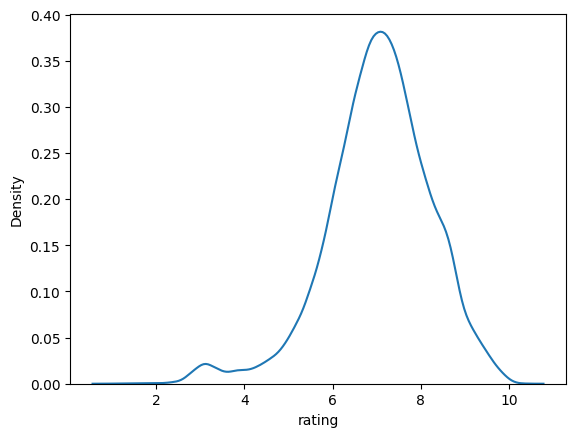

In [101]:
sns.kdeplot(df_sample_submission['rating'])

In [102]:
# target label transform은 성능 떨어짐(train : 2.18 -> 2.29)
# Age Binning 구간은 성능 차이 없음
# Cardinality 축소도 성능 차이 없음
# Feature Selection은 신중히 하자

# Overfiting, Top-Ranker

In [103]:
# 2.1242165243553117 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
# 2.1233636361569754 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}
# 2.124190588122351 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
# 2.1213700377152285 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}